In [1]:

from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier, XGBClassifier

from sklearn.decomposition import PCA # TruncatedSVD is more efficient on large datasets
# from sklearn.svm import LinearSVC, NuSVC, SVC # memory intensive and trains, and predicts very slowly
# from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

# GradientBoostingClassifier takes much longer to train than everything else I tried except SVM's
# from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import tensorflow
import seaborn
import pandas
import numpy
import time


In [2]:

import warnings

warnings.filterwarnings('ignore')


In [3]:

target = 'transition' # what we are trying to predict
base_dir = 'C:\\Users\\Michael\\Desktop\\'

trans_data_path = f'{base_dir}transitions.csv'

exclude = ['symbol', 't_time', 'n_time', 'throughtput', 'E0', target] # these will not be features

# E0 is a function of lambda


In [4]:

transition_data = pandas.read_csv(trans_data_path)
transition_data = transition_data[transition_data['n_time'] >= pandas.Timestamp('2020-01-01').value]

localized_time_of_day = transition_data['n_time'].astype('datetime64[ns]')
localized_time_of_day = localized_time_of_day.dt.tz_localize('UTC').dt.tz_convert('America/New_York')
localized_time_of_day = localized_time_of_day - localized_time_of_day.dt.floor('1D')
localized_time_of_day = localized_time_of_day.dt.total_seconds() / 60 # in minutes

transition_data = transition_data[localized_time_of_day < 955] # remove transitions that start after 3:55 pm EST

localized_time_of_day = transition_data['t_time'].astype('datetime64[ns]')
localized_time_of_day = localized_time_of_day.dt.tz_localize('UTC').dt.tz_convert('America/New_York')
localized_time_of_day = localized_time_of_day - localized_time_of_day.dt.floor('1D')
localized_time_of_day = localized_time_of_day.dt.total_seconds() / 60 # in minutes

transition_data.loc[localized_time_of_day >= 955, target] = 0 # set all transitions that end after 3:55 pm EST to 0

del localized_time_of_day

print('DATAFRAME SHAPE :', transition_data.shape)

# this includes trades that were filtered out
print('AMOUNT OF DATA ANALYZED :', round(transition_data['throughtput'].sum() * 1e-12, 4), 'TB.\n')

print(list(transition_data.columns), '\n')

transition_data.info()


DATAFRAME SHAPE : (15305960, 21)
AMOUNT OF DATA ANALYZED : 9.5718 TB.

['vsum', 'rolling_vsum', 'rolling_csum', 'dp', 'dt', 'n_time', 'price', 'size', 'n', 'transition', 't_time', 'throughtput', 'previous_days_close', 'average_volume', 'symbol', 'mean', 'std', 'p(-dx)', 'p(+dx)', 'E0', 'lambda'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15305960 entries, 2 to 17352242
Data columns (total 21 columns):
 #   Column               Dtype  
---  ------               -----  
 0   vsum                 float64
 1   rolling_vsum         float64
 2   rolling_csum         float64
 3   dp                   float64
 4   dt                   float64
 5   n_time               int64  
 6   price                float64
 7   size                 float64
 8   n                    int64  
 9   transition           int64  
 10  t_time               int64  
 11  throughtput          float64
 12  previous_days_close  float64
 13  average_volume       float64
 14  symbol               int64  
 15  mea

### Add new features
* Add time_of_day using n_time. time_of_day will be in terms of minutes from the last day in UTC time.
* Add relative_volume using average_volume and vsum. 
* convert dp to a relative return.

In [5]:

transition_data['time_of_day'] = transition_data['n_time'].astype('datetime64[ns]')
transition_data['time_of_day'] = transition_data['time_of_day'] - transition_data['time_of_day'].dt.floor('1D')
transition_data['time_of_day'] = transition_data['time_of_day'].dt.total_seconds() / 60 # in minutes

transition_data['relative_volume'] = transition_data['vsum'] / transition_data['average_volume']
transition_data['dp'] = transition_data['price'] / (transition_data['price'] - transition_data['dp'])


In [6]:

features = [i for i in transition_data.columns if not i in exclude]


### Clean the data
Handle nulls if there are any.

In [7]:

transition_data.isnull().sum() # handle relative_volume nulls by removing entries where average_volume <= 0


vsum                      0
rolling_vsum              0
rolling_csum              0
dp                        0
dt                        0
n_time                    0
price                     0
size                      0
n                         0
transition                0
t_time                    0
throughtput               0
previous_days_close       0
average_volume            0
symbol                    0
mean                      0
std                       0
p(-dx)                    0
p(+dx)                    0
E0                        0
lambda                    0
time_of_day               0
relative_volume        1271
dtype: int64

Clamp transitions between -1 and 1; I chose the target to be the direction of the transition, not the magnitude. <br>
Remove transitions where rolling_csum < 5 means that there was less than 5 trades in the past two seconds. <br>
dt == 0 means that the last trade occured more than 2 seconds ago. <br>
vsum == 0 means that no trades have occurred today since the aggregation of the last minute bar.

In [8]:

print('Entries before cleaning :', len(transition_data))

transition_data['transition'].clip(-1, 1, inplace=True)

transition_data = transition_data[transition_data['transition']**2 <= 1]
transition_data = transition_data[transition_data['rolling_csum'] >= 5]
transition_data = transition_data[transition_data['dt'] > 0.0]
transition_data = transition_data[transition_data['vsum'] > 0]
transition_data = transition_data[transition_data['average_volume'] > 0.0]

print('Entries after cleaning :', len(transition_data))


Entries before cleaning : 15305960
Entries after cleaning : 2038514


Check the domain of each feature. <br>
All values for price, size, dt, dp, average_volume, previous_days_close, std, lambda, and n_time should be > 0 with no exceptions.

In [9]:

(transition_data <= 0.0).sum() # no issues here


vsum                         0
rolling_vsum                 0
rolling_csum                 0
dp                           0
dt                           0
n_time                       0
price                        0
size                         0
n                       962838
transition             1229954
t_time                       0
throughtput                  0
previous_days_close          0
average_volume               0
symbol                       0
mean                         0
std                          0
p(-dx)                    2890
p(+dx)                    2426
E0                           0
lambda                       0
time_of_day                  0
relative_volume              0
dtype: int64

### Split data into train/validation/test
Data is split by time period: 80% of the data is used for training, 10% for validation, and 10% for testing.

In [10]:

time_min = transition_data.n_time.min()
time_max = transition_data.n_time.max()

train_vali_split = 0.2 * time_min + 0.8 * time_max
vali_test_split = 0.1 * time_min + 0.9 * time_max

train_data = transition_data[transition_data.n_time <= train_vali_split]
vali_data = transition_data[(transition_data.n_time > train_vali_split) & (transition_data.n_time <= vali_test_split)]
test_data = transition_data[(transition_data.n_time >= vali_test_split)]


### Check sizes of data sets
Check to make sure that the sizes of the train, validation, and test sets are proportional to the time periods they span. <br>
Example: the first 80% of the time period of the original data set is the time span of the train set, so around 80% of the data should be in the train set.

In [11]:

train_data_len = len(train_data)
vali_data_len = len(vali_data)
test_data_len = len(test_data)

total_len = train_data_len + vali_data_len + test_data_len

print('TRAIN DATA ABSOLUTE / RELATIVE LENGTH :', train_data_len, '/', train_data_len / total_len)
print('VALIDATION DATA ABSOLUTE / RELATIVE LENGTH :', vali_data_len, '/', vali_data_len / total_len)
print('TEST DATA ABSOLUTE / RELATIVE LENGTH :', test_data_len, '/', test_data_len / total_len)


TRAIN DATA ABSOLUTE / RELATIVE LENGTH : 1706021 / 0.8368944240755766
VALIDATION DATA ABSOLUTE / RELATIVE LENGTH : 164501 / 0.08069652697994716
TEST DATA ABSOLUTE / RELATIVE LENGTH : 167992 / 0.08240904894447622


### Check the distributions of each feature
Only train data is analysed.

array([[<AxesSubplot:title={'center':'vsum'}>,
        <AxesSubplot:title={'center':'rolling_vsum'}>,
        <AxesSubplot:title={'center':'rolling_csum'}>,
        <AxesSubplot:title={'center':'dp'}>],
       [<AxesSubplot:title={'center':'dt'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'size'}>,
        <AxesSubplot:title={'center':'n'}>],
       [<AxesSubplot:title={'center':'previous_days_close'}>,
        <AxesSubplot:title={'center':'average_volume'}>,
        <AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'std'}>],
       [<AxesSubplot:title={'center':'p(-dx)'}>,
        <AxesSubplot:title={'center':'p(+dx)'}>,
        <AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'time_of_day'}>],
       [<AxesSubplot:title={'center':'relative_volume'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

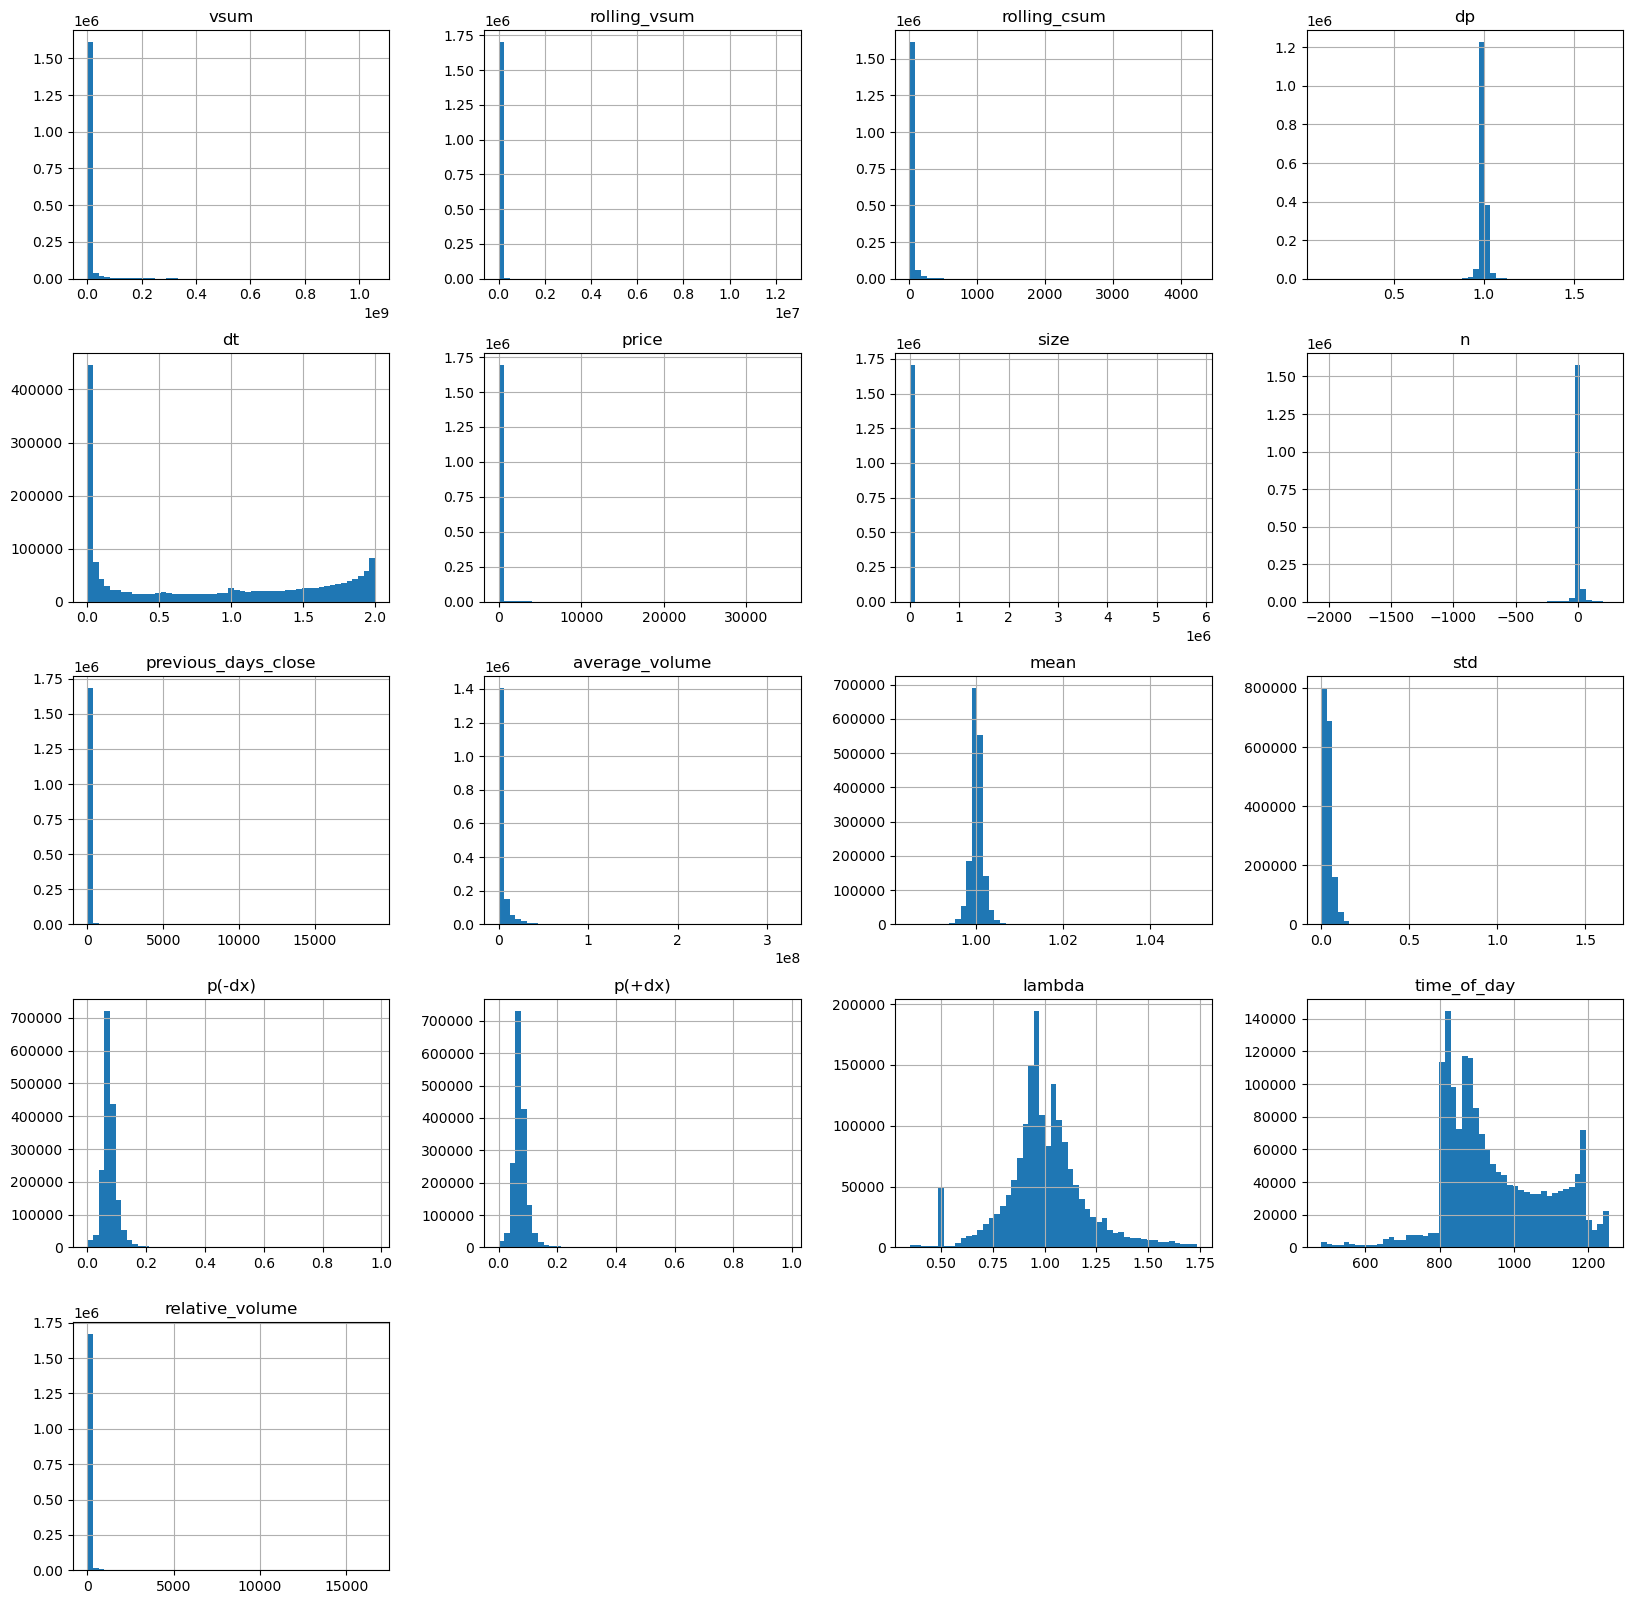

In [12]:

train_data[features].hist(bins=51, figsize=(20,20))


### Transform Data
Many of the features are log-normally distributed. A log transformation is applied to those features to make them more normally distributed. <br>
After that the features will be standardized.

In [13]:

def transform(data, scaler, fit=False):
    
    for feature in ['vsum', 'rolling_vsum', 'rolling_csum', 'dt', 'dp', 'price', 'size', 'previous_days_close',
                    'average_volume', 'mean', 'std', 'p(-dx)', 'p(+dx)', 'lambda', 'relative_volume']:
        
        data[feature] = numpy.log(1e-9 + data[feature])
        
    if fit: data[features] = scaler.fit_transform(data[features])
    else:
        re_features = scaler.feature_names_in_
        data[re_features] = scaler.transform(data[re_features])
        
def inverse_transform(data, scaler):
    
    re_features = scaler.feature_names_in_
    
    data[re_features] = scaler.inverse_transform(data[re_features])
    
    for feature in ['vsum', 'rolling_vsum', 'rolling_csum', 'dt', 'dp', 'price', 'size', 'previous_days_close',
                    'average_volume', 'mean', 'std', 'p(-dx)', 'p(+dx)', 'lambda', 'relative_volume']:
        
        data[feature] = numpy.exp(data[feature]) - 1e-9
        

array([[<AxesSubplot:title={'center':'vsum'}>,
        <AxesSubplot:title={'center':'rolling_vsum'}>,
        <AxesSubplot:title={'center':'rolling_csum'}>,
        <AxesSubplot:title={'center':'dp'}>],
       [<AxesSubplot:title={'center':'dt'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'size'}>,
        <AxesSubplot:title={'center':'n'}>],
       [<AxesSubplot:title={'center':'previous_days_close'}>,
        <AxesSubplot:title={'center':'average_volume'}>,
        <AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'std'}>],
       [<AxesSubplot:title={'center':'p(-dx)'}>,
        <AxesSubplot:title={'center':'p(+dx)'}>,
        <AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'time_of_day'}>],
       [<AxesSubplot:title={'center':'relative_volume'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

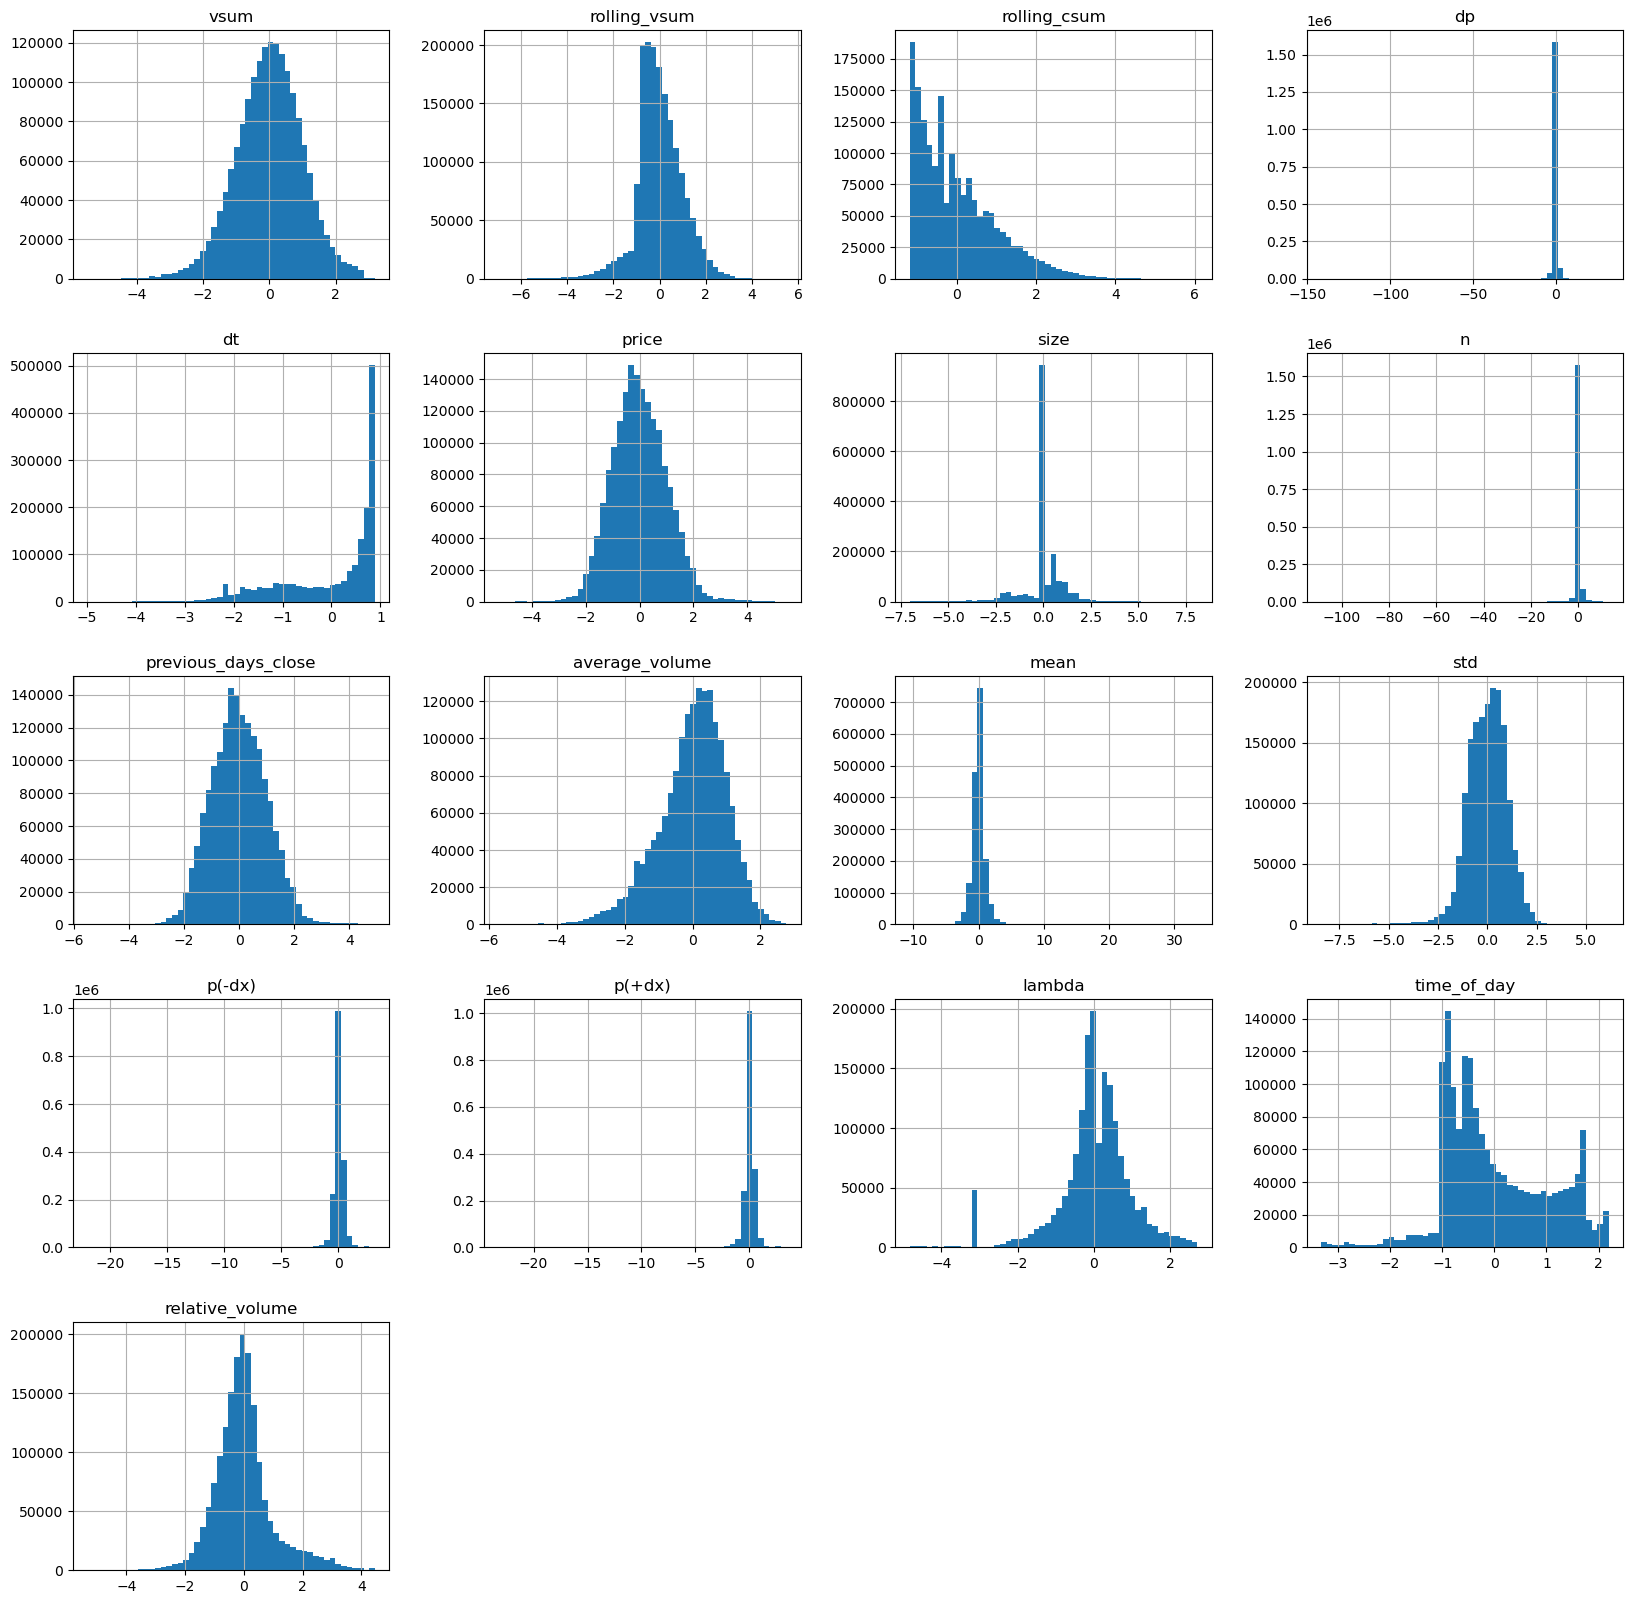

In [14]:

scaler = StandardScaler()

transform(train_data, scaler, True)
transform(vali_data, scaler)
transform(test_data, scaler)

train_data[features].hist(bins=51, figsize=(20,20))


### Remove outliers
Remove any row with a feature that is more than 3 standard deviations away from its mean. <br>
Remember that the transformations applied to the train set were also applied to the validation and test data but the fitting was only done with the training data.

In [15]:

def remove_outliers(transformed_and_scaled_data):
    
    exclude = (transformed_and_scaled_data[features]**2 > 9).any(axis=1)
    
    transformed_and_scaled_data.drop(transformed_and_scaled_data[exclude].index, inplace=True)
    
    return exclude.sum()


In [16]:

print(remove_outliers(train_data), 'rows removed from train set.')
print(remove_outliers(vali_data), 'rows removed from validation set.')
print(remove_outliers(test_data), 'rows removed from test set.')


235817 rows removed from train set.
34102 rows removed from validation set.
46356 rows removed from test set.


### Check Skewness
In general, if the skewness of a feature is < -1 or > 1 then the feature is considered skewed. <br>
From the distributions we can see that some of the features were already heavily skewed before transformation.

In [17]:

train_data[features].skew()


vsum                  -0.089624
rolling_vsum           0.229831
rolling_csum           0.873334
dp                    -0.177884
dt                    -0.949438
price                  0.075196
size                  -0.600373
n                      1.468092
previous_days_close    0.031426
average_volume        -0.389407
mean                   0.043956
std                   -0.095189
p(-dx)                 0.056340
p(+dx)                 0.310096
lambda                 0.069862
time_of_day            0.436185
relative_volume        0.547415
dtype: float64

### Check for linear relationships
Check for highly correlated features using a heatmap or pairplot. <br>
In general, coefficients > 0.7 or < -0.7 indicate highly correlated values. <br>
Spearman coefficients are used in the heatmap.

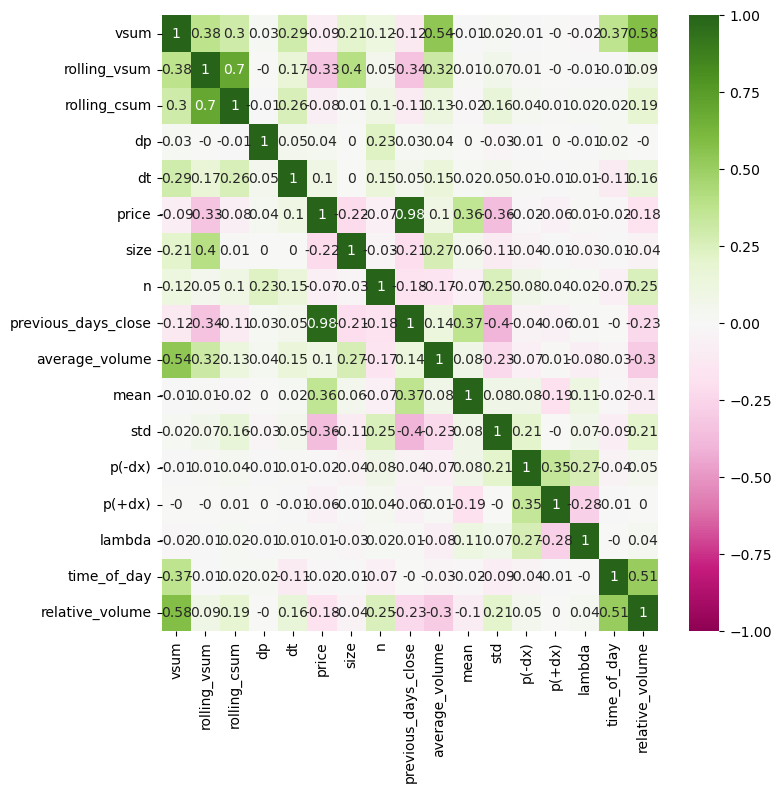

In [18]:

coefficients = train_data[features].corr(method='spearman').round(2)

plt.figure(figsize=(8, 8))

seaborn.heatmap(coefficients, annot=True, cmap='PiYG', vmin=-1, vmax=1)

plt.show()


### Study the highly correlated features
Decide which features to further exclude if any.

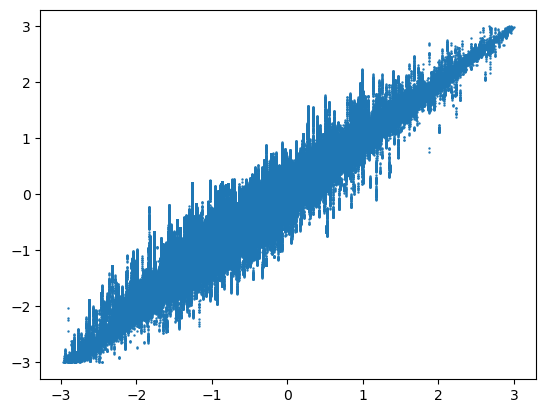

In [19]:

plt.scatter(train_data['previous_days_close'], train_data['price'], s=0.5)
plt.show()


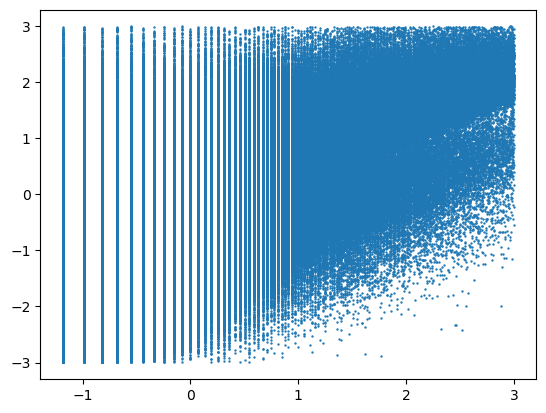

In [20]:

plt.scatter(train_data['rolling_csum'], train_data['rolling_vsum'], s=0.5)
plt.show()


The previous day's close and price appear to be highly correlated (which is kind of expected). Price should be discarded for the following reasons:
* Price needs to be updated more frequently than the previous day's closing price - every tick vs every day. <br>
* Price can be very closely estimated with n, E0, and std with the formula for quantum price levels.

In [21]:

features.remove('price')


### Check feature correlations with the target variable

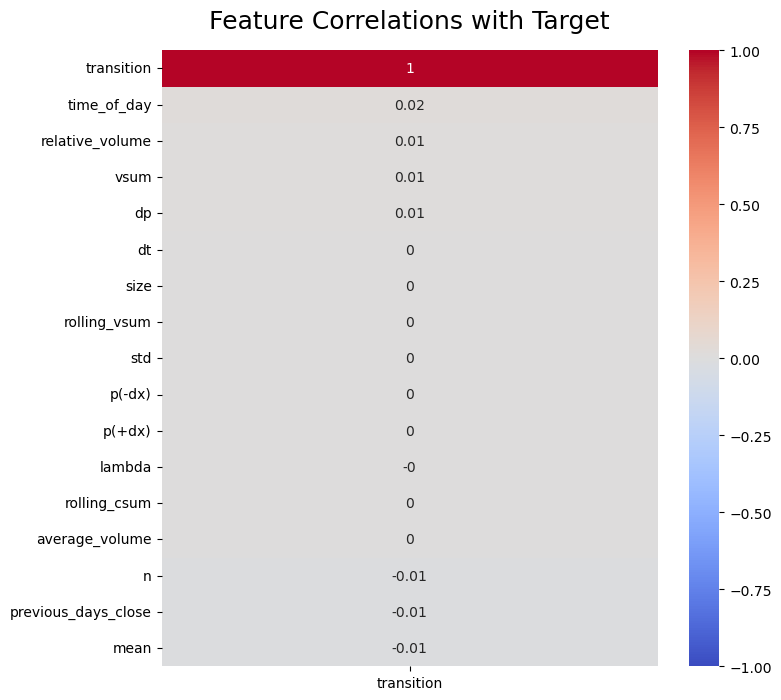

In [22]:

coefficients = train_data[features+[target]].corr(method='spearman').round(2)[[target]]

coefficients.sort_values(by=target, ascending=False, inplace=True)

plt.figure(figsize=(8, 8))

heatmap = seaborn.heatmap(coefficients, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

heatmap.set_title('Feature Correlations with Target', fontdict={'fontsize':18}, pad=16)

plt.show()


### Check the sampling of the target feature in each data set
Make sure that the distribution of transitions are the same in each data set (same percentage of -1's, 0's, and 1's in each set). <br>
For supervised learning to be effective, the sample space of the unseen data must be similar to the training data.

In [23]:

def plot_sample(sample, title, label, scheme):
    
    plt.figure(figsize=(8, 2))
    
    seaborn.heatmap(sample, cmap=scheme, annot=True, xticklabels=['-1','0','1'], yticklabels=[''], vmin=0, vmax=1)
    
    plt.title(title, fontsize=16)
    plt.xlabel(label, fontsize=12)
    
    plt.show()
    

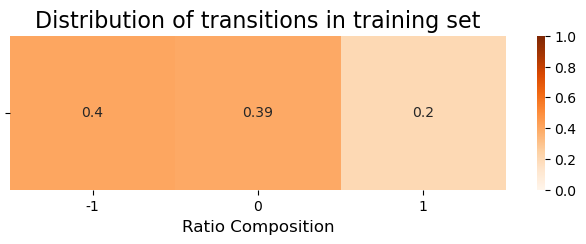

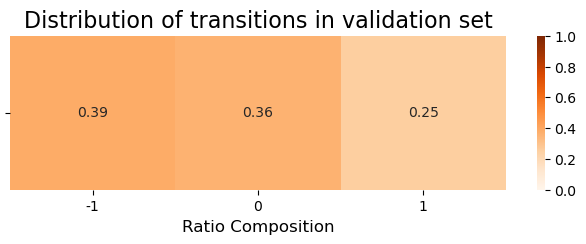

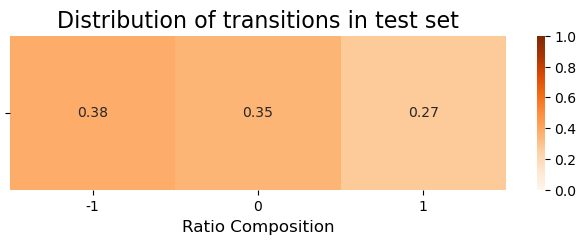

In [24]:

train_sample = numpy.array(train_data[target].value_counts())[None,:] / len(train_data)
vali_sample = numpy.array(vali_data[target].value_counts())[None,:] / len(vali_data)
test_sample = numpy.array(test_data[target].value_counts())[None,:] / len(test_data)

plot_sample(train_sample, 'Distribution of transitions in training set', 'Ratio Composition', 'Oranges')
plot_sample(vali_sample, 'Distribution of transitions in validation set', 'Ratio Composition', 'Oranges')
plot_sample(test_sample, 'Distribution of transitions in test set', 'Ratio Composition', 'Oranges')


### Further preprocess with PCA
If no robust models are obtained from model exploration, try PCA, and then redo model exploration.

In [25]:

use_pca = False

if use_pca:
    pca = PCA().fit(train_data[features])
    
    plt.plot(numpy.arange(len(features)) + 1, pca.explained_variance_ratio_.cumsum())
    
    plt.title('Explained Variance vs # of Features', fontsize=16)
    plt.ylabel('Total Explained Variance', fontsize=12)
    plt.xlabel('# of Features', fontsize=12)
    
    plt.show()
    

In [26]:

# select the number of PCA components to use as your new features if using PCA

n_components = len(features) # replace with however many to use

if use_pca:
    x_train = pca.transform(train_data[features])[:,:n_components]
    x_vali = pca.transform(vali_data[features])[:,:n_components]
    x_test = pca.transform(test_data[features])[:,:n_components]
    
else:
    x_train = train_data[features]
    x_vali = vali_data[features]
    x_test = test_data[features]
    
y_train = train_data[target]
y_vali = vali_data[target]
y_test = test_data[target]


### Explore various models
Explore various Machine Learning models and hyperparameters in order to find the best possible model. <br>
After finding a suitable ML model try using neural nets to get a better model. <br>
If no stable model is obtained then try using Principal Component Analysis (PCA) to further pre-process the already-transformed-and-scaled data.

In [27]:

# takes a list of lists of argument variables and a dictionary of lists of keyword argument variables ...
# ... and returns all possible combinations of those arguments

def get_argument_sets(args=[], kwargs={}):
    
    sets = []
    
    for arg in args:
        if not sets:
            sets = [([arg_var],{}) for arg_var in arg]
            
            continue
            
        new_sets = []
        
        for arg_set, kwarg_set in sets: new_sets.extend([(arg_set + [arg_var], kwarg_set) for arg_var in arg])
        
        sets = new_sets
        
    for kwarg, kwval in kwargs.items():
        if not sets:
            sets = [([],{kwarg:kwarg_var}) for kwarg_var in kwval]
            
            continue
            
        new_sets = []
        
        for arg_set, kwarg_set in sets:
            new_kwarg_sets = []
            
            for kwarg_var in kwval:
                new_kwarg_set = kwarg_set.copy()
                
                new_kwarg_set[kwarg] = kwarg_var
                
                new_kwarg_sets.append((arg_set, new_kwarg_set))
                
            new_sets.extend(new_kwarg_sets)
        
        sets = new_sets
        
    return sets


In [28]:

def get_accuracy(true_values, predictions): # get the accuracy for each transition
    
    cm = confusion_matrix(true_values, predictions)
    
    return (cm / cm.sum(axis=0)).diagonal()[None,:]


In [29]:

def train_models(model_types, model_params, all_params, x_train, y_train, x_vali, y_vali, log):
    
    models = {}
    model_results = {}
    
    for model_type, classifier in model_types.items():
        trained_models = []
        results = []
        
        for args, kwargs in model_params[model_type]:
            clf = classifier(*args, **kwargs)
            
            # Categorical targets for these model types must be encoded to non-negative integers
            if model_type in ['XGBRF', 'XGB']: offset = 1
            else: offset = 0
            
            train_time = time.time()
            
            clf.fit(x_train, y_train + offset)
            
            train_time = time.time() - train_time
            
            train_predictions = clf.predict(x_train) - offset
            train_probabilities = clf.predict_proba(x_train)
            
            vali_predictions = clf.predict(x_vali) - offset
            vali_probabilities = clf.predict_proba(x_vali)
            
            train_loss = log_loss(y_train, train_probabilities)
            vali_loss = log_loss(y_vali, vali_probabilities)
            
            train_accuracy = get_accuracy(y_train, train_predictions)
            vali_accuracy = get_accuracy(y_vali, vali_predictions)
            
            train_results = {'train_loss':train_loss, 'vali_loss':vali_loss, 'train_accuracy':train_accuracy,
                             'vali_accuracy':vali_accuracy, 'train_time':train_time}
            
            train_results.update({param:kwargs.get(param) for param in all_params})
            
            trained_models.append(clf)
            results.append(train_results)
            
            if log:
                print('TIME TO TRAIN', model_type, 'WITH PARAMETERS :', args, kwargs)
                print('\t', train_time / 60, 'MINUTES.\n')
                print('TRAIN RESULTS :')
                print('\tLOSS :', train_loss)
                print('\tACCURACY :', train_accuracy, '\n')
                print('VALIDATION RESULTS :\n')
                print('\tLOSS :', vali_loss)
                print('\tACCURACY :', vali_accuracy, '\n\n')
                
        model_results[model_type] = results
        models[model_type] = trained_models
        
    return models, model_results


In [30]:

objectives = ['multi:softprob']
n_estimators = [50, 100, 250, 500]
max_depth = [2, 3, 4, 5]
learning_rate = [1e-3]
n_jobs = [6] # number of cpus you are willing to use

all_params = ['max_depth', 'n_estimators', 'learning_rate'] # only include the parameters we might change

model_types = {'LGBM':LGBMClassifier, 'XGBRF':XGBRFClassifier, 'XGB':XGBClassifier, 'DT':DecisionTreeClassifier,
               'ET':ExtraTreeClassifier, 'AdaB':AdaBoostClassifier, 'RF':RandomForestClassifier,
               'HGB':HistGradientBoostingClassifier}

model_params = {'DT':get_argument_sets([],{'max_depth':max_depth}),
                'ET':get_argument_sets([],{'max_depth':max_depth}),
                'RF':get_argument_sets([],{'n_estimators':n_estimators, 'max_depth':max_depth, 'n_jobs':n_jobs}),
                'LGBM':get_argument_sets([],{'max_depth':max_depth, 'n_estimators':n_estimators, 'n_jobs':n_jobs,
                                             'learning_rate':learning_rate, 'objective':objectives}),
                'XGB':get_argument_sets([],{'max_depth':max_depth, 'n_estimators':n_estimators, 'n_jobs':n_jobs,
                                            'learning_rate':learning_rate, 'objective':objectives}),
                'XGBRF':get_argument_sets([],{'max_depth':max_depth, 'n_estimators':n_estimators, 'n_jobs':n_jobs,
                                              'learning_rate':learning_rate, 'objective':objectives}),
                'AdaB':get_argument_sets([],{'n_estimators':n_estimators, 'learning_rate':learning_rate}),
                'HGB':get_argument_sets([],{'max_depth':max_depth, 'learning_rate':learning_rate})}

# model_types['GB'] = GradientBoostingClassifier
# model_params['GB'] = get_argument_sets([],{'n_estimators':n_estimators, 'max_depth':max_depth,
#                                            'learning_rate':learning_rate})

models, model_results = train_models(model_types, model_params, all_params, x_train, y_train, x_vali, y_vali, False)


### Compare the accuracy and loss on the train and validation sets
See if there are any major differences in the train and validation predictions.

In [31]:

# pack the results into a dataframe for easier access

def pack_results(all_params, model_results):
    
    model_results_columns = ['transition', 'loss', 'accuracy', 'parameter_set'] + all_params
    model_results_df = []
    
    transitions = numpy.array([-1,0,1])[:,None]
    
    for method, results in model_results.items():
        train_results_df = []
        vali_results_df = []
        parameter_set = 0
        
        for result in results:
            params = [numpy.tile(result[param], (3,1)) for param in all_params]
            
            train_rows = numpy.concatenate([transitions, numpy.tile([result['train_loss']], (3,1)),
                                            result['train_accuracy'][0,:,None],
                                            parameter_set * numpy.ones(3)[:,None]] + params, axis=1)
            
            vali_rows = numpy.concatenate([transitions, numpy.tile([result['vali_loss']], (3,1)),
                                           result['vali_accuracy'][0,:,None],
                                           parameter_set * numpy.ones(3)[:,None]] + params, axis=1)
            parameter_set += 1
            
            train_results_df.append(train_rows)
            vali_results_df.append(vali_rows)
            
        train_results_df = pandas.DataFrame(data=numpy.concatenate(train_results_df), columns=model_results_columns)
        vali_results_df = pandas.DataFrame(data=numpy.concatenate(vali_results_df), columns=model_results_columns)
        
        train_results_df['set'] = 'train'
        vali_results_df['set'] = 'validation'
        
        train_results_df['method'] = method
        vali_results_df['method'] = method
        
        model_results_df.append(train_results_df)
        model_results_df.append(vali_results_df)
        
    model_results_df = pandas.concat(model_results_df)
    
    print('Hyperparameter combinations per model type')
    print(model_results_df['method'].value_counts() // 6)
    
    return model_results_df


In [32]:

model_results_df = pack_results(all_params, model_results)

model_results_df


Hyperparameter combinations per model type
LGBM     16
XGBRF    16
XGB      16
RF       16
DT        4
ET        4
AdaB      4
HGB       4
Name: method, dtype: int64


transition      loss  accuracy parameter_set max_depth n_estimators  \
0        -1.0  1.047641  0.404631           0.0       2.0         50.0   
1         0.0  1.047641       NaN           0.0       2.0         50.0   
2         1.0  1.047641  0.353958           0.0       2.0         50.0   
3        -1.0  1.040225  0.405328           1.0       2.0        100.0   
4         0.0  1.040225       NaN           1.0       2.0        100.0   
..        ...       ...       ...           ...       ...          ...   
7           0  1.056596       NaN           2.0         4         None   
8           1  1.056596    0.4243           2.0         4         None   
9          -1  1.052989   0.39937           3.0         5         None   
10          0  1.052989       NaN           3.0         5         None   
11          1  1.052989  0.445375           3.0         5         None   

   learning_rate         set method  
0          0.001       train   LGBM  
1          0.001       train   LGBM  
2          0.001       train   LGBM  
3          0.001       train   LGBM  
4          0.001       train   LGBM  
..           ...         ...    ...  
7          0.001  validation    HGB  
8          0.001  validation    HGB  
9          0.001  validation    HGB  
10         0.001  validation    HGB  
11         0.001  validation    HGB  

[480 rows x 9 columns]

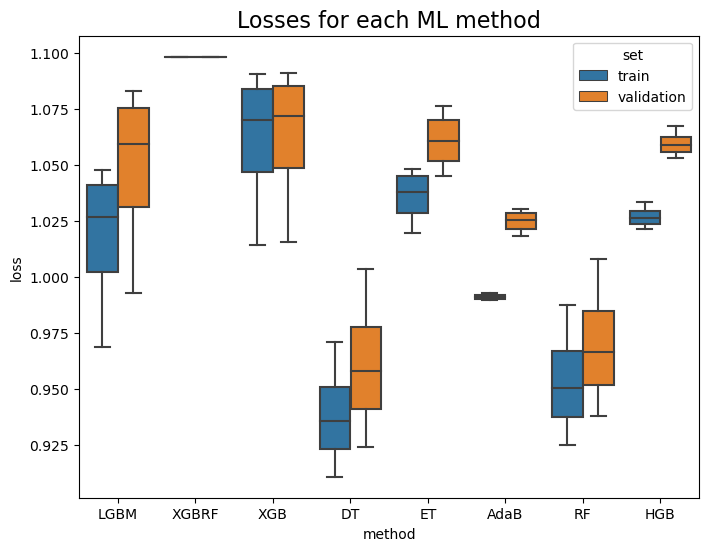

In [33]:

plt.figure(figsize=(8, 6))

seaborn.boxplot(x='method', y='loss', hue='set', data=model_results_df.query('transition==0'))

plt.title('Losses for each ML method', fontsize=16)

plt.show()


From the figure above, it looks like most of the losses are relatively close to each other. Decission Trees and Random Forest models appear to be consistently lower than the rest of the methods however, the difference is not large enough to suggest that they are any more predictive than the other model types. Based on this information alone, no model type should be further excluded from exploration.

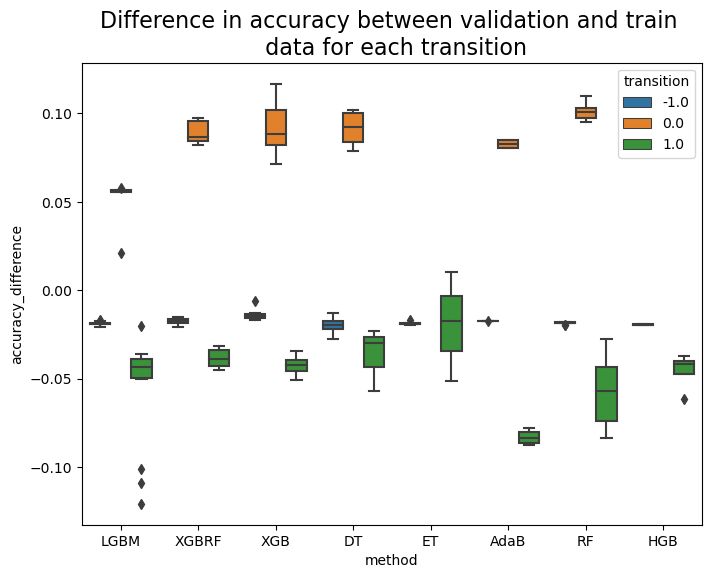

In [34]:

plt.figure(figsize=(8, 6))

train_accuracy_df = model_results_df.query('set=="train"')
vali_accuracy_df = model_results_df.query('set=="validation"')

train_accuracy_df.sort_values(['parameter_set', 'transition'], inplace=True)
vali_accuracy_df.sort_values(['parameter_set', 'transition'], inplace=True)

train_accuracy_df.reset_index(inplace=True)
vali_accuracy_df.reset_index(inplace=True)

train_accuracy_df['accuracy_difference'] = vali_accuracy_df['accuracy'] - train_accuracy_df['accuracy']

seaborn.boxplot(x='method', y='accuracy_difference', hue='transition', data=train_accuracy_df)

plt.title('Difference in accuracy between validation and train \n data for each transition', fontsize=16)

plt.show()


#### Conclusions
* Based on the figure above, it seems that all of the models have a large accuracy difference for 0 transitions with the 1st and 2nd lowest being LGBM and AdaB classifiers respectively. <br>
* In terms of accuracy, all models seem to be the most consistent in predicting -1 transitions, and the ET models appear to be the most consistent in predicting +1 transitions, and the worst at predicting 0 transitions. <br>
* There seems to be systematic overfitting due to the large accuracy difference in predicting 0 and +1 transitions.

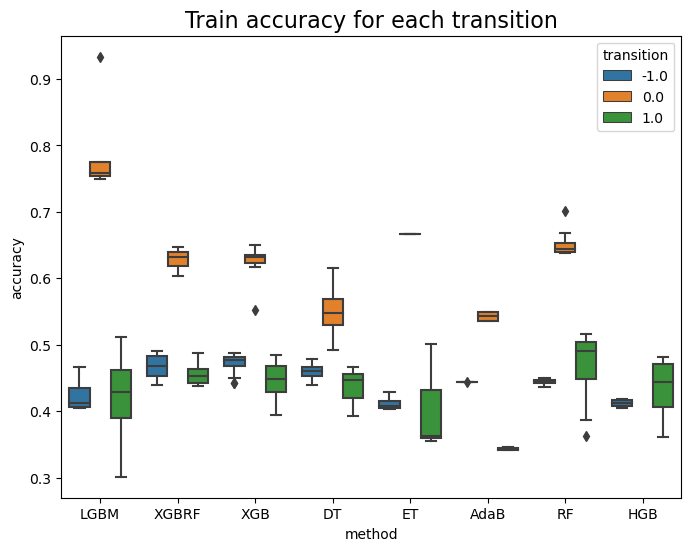

In [35]:

plt.figure(figsize=(8, 6))

seaborn.boxplot(x='method', y='accuracy', hue='transition', data=model_results_df.query('set=="train"'))

plt.title('Train accuracy for each transition', fontsize=16)

plt.show()


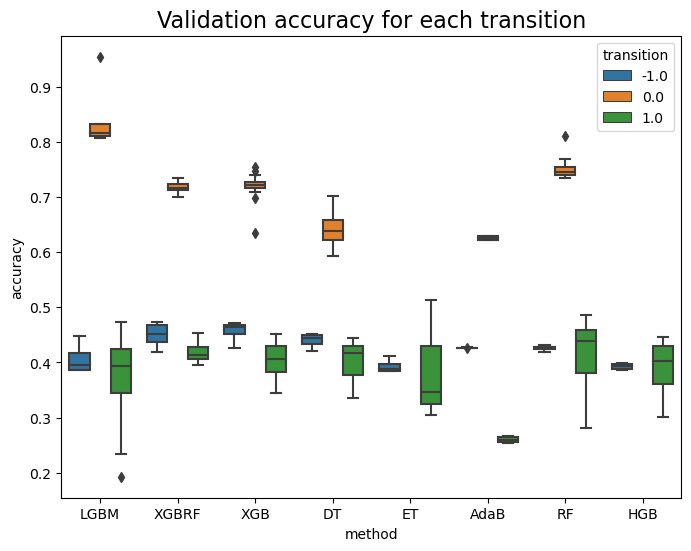

In [36]:

plt.figure(figsize=(8, 6))

seaborn.boxplot(x='method', y='accuracy', hue='transition', data=model_results_df.query('set=="validation"'))

plt.title('Validation accuracy for each transition', fontsize=16)

plt.show()


#### Conclusions
* Based on the two previous figures, The XGB and XGBRF Models have the highest overall accuracies for -1 transitions. <br>
* The LGBM models have the highest overall accuracy for 0 transitions. <br>
* The RF models have the highest overall accuracies for +1 transitions and the ET has some of the highest. <br>

Based on this information and the three figures above, the LGBM, XGB, XGBRF, ET, and RF model types should be further explored and the rest should be discarded.

### Hyperparameter comparison
Explore the results with respect to hyperparameters of the remaining models.

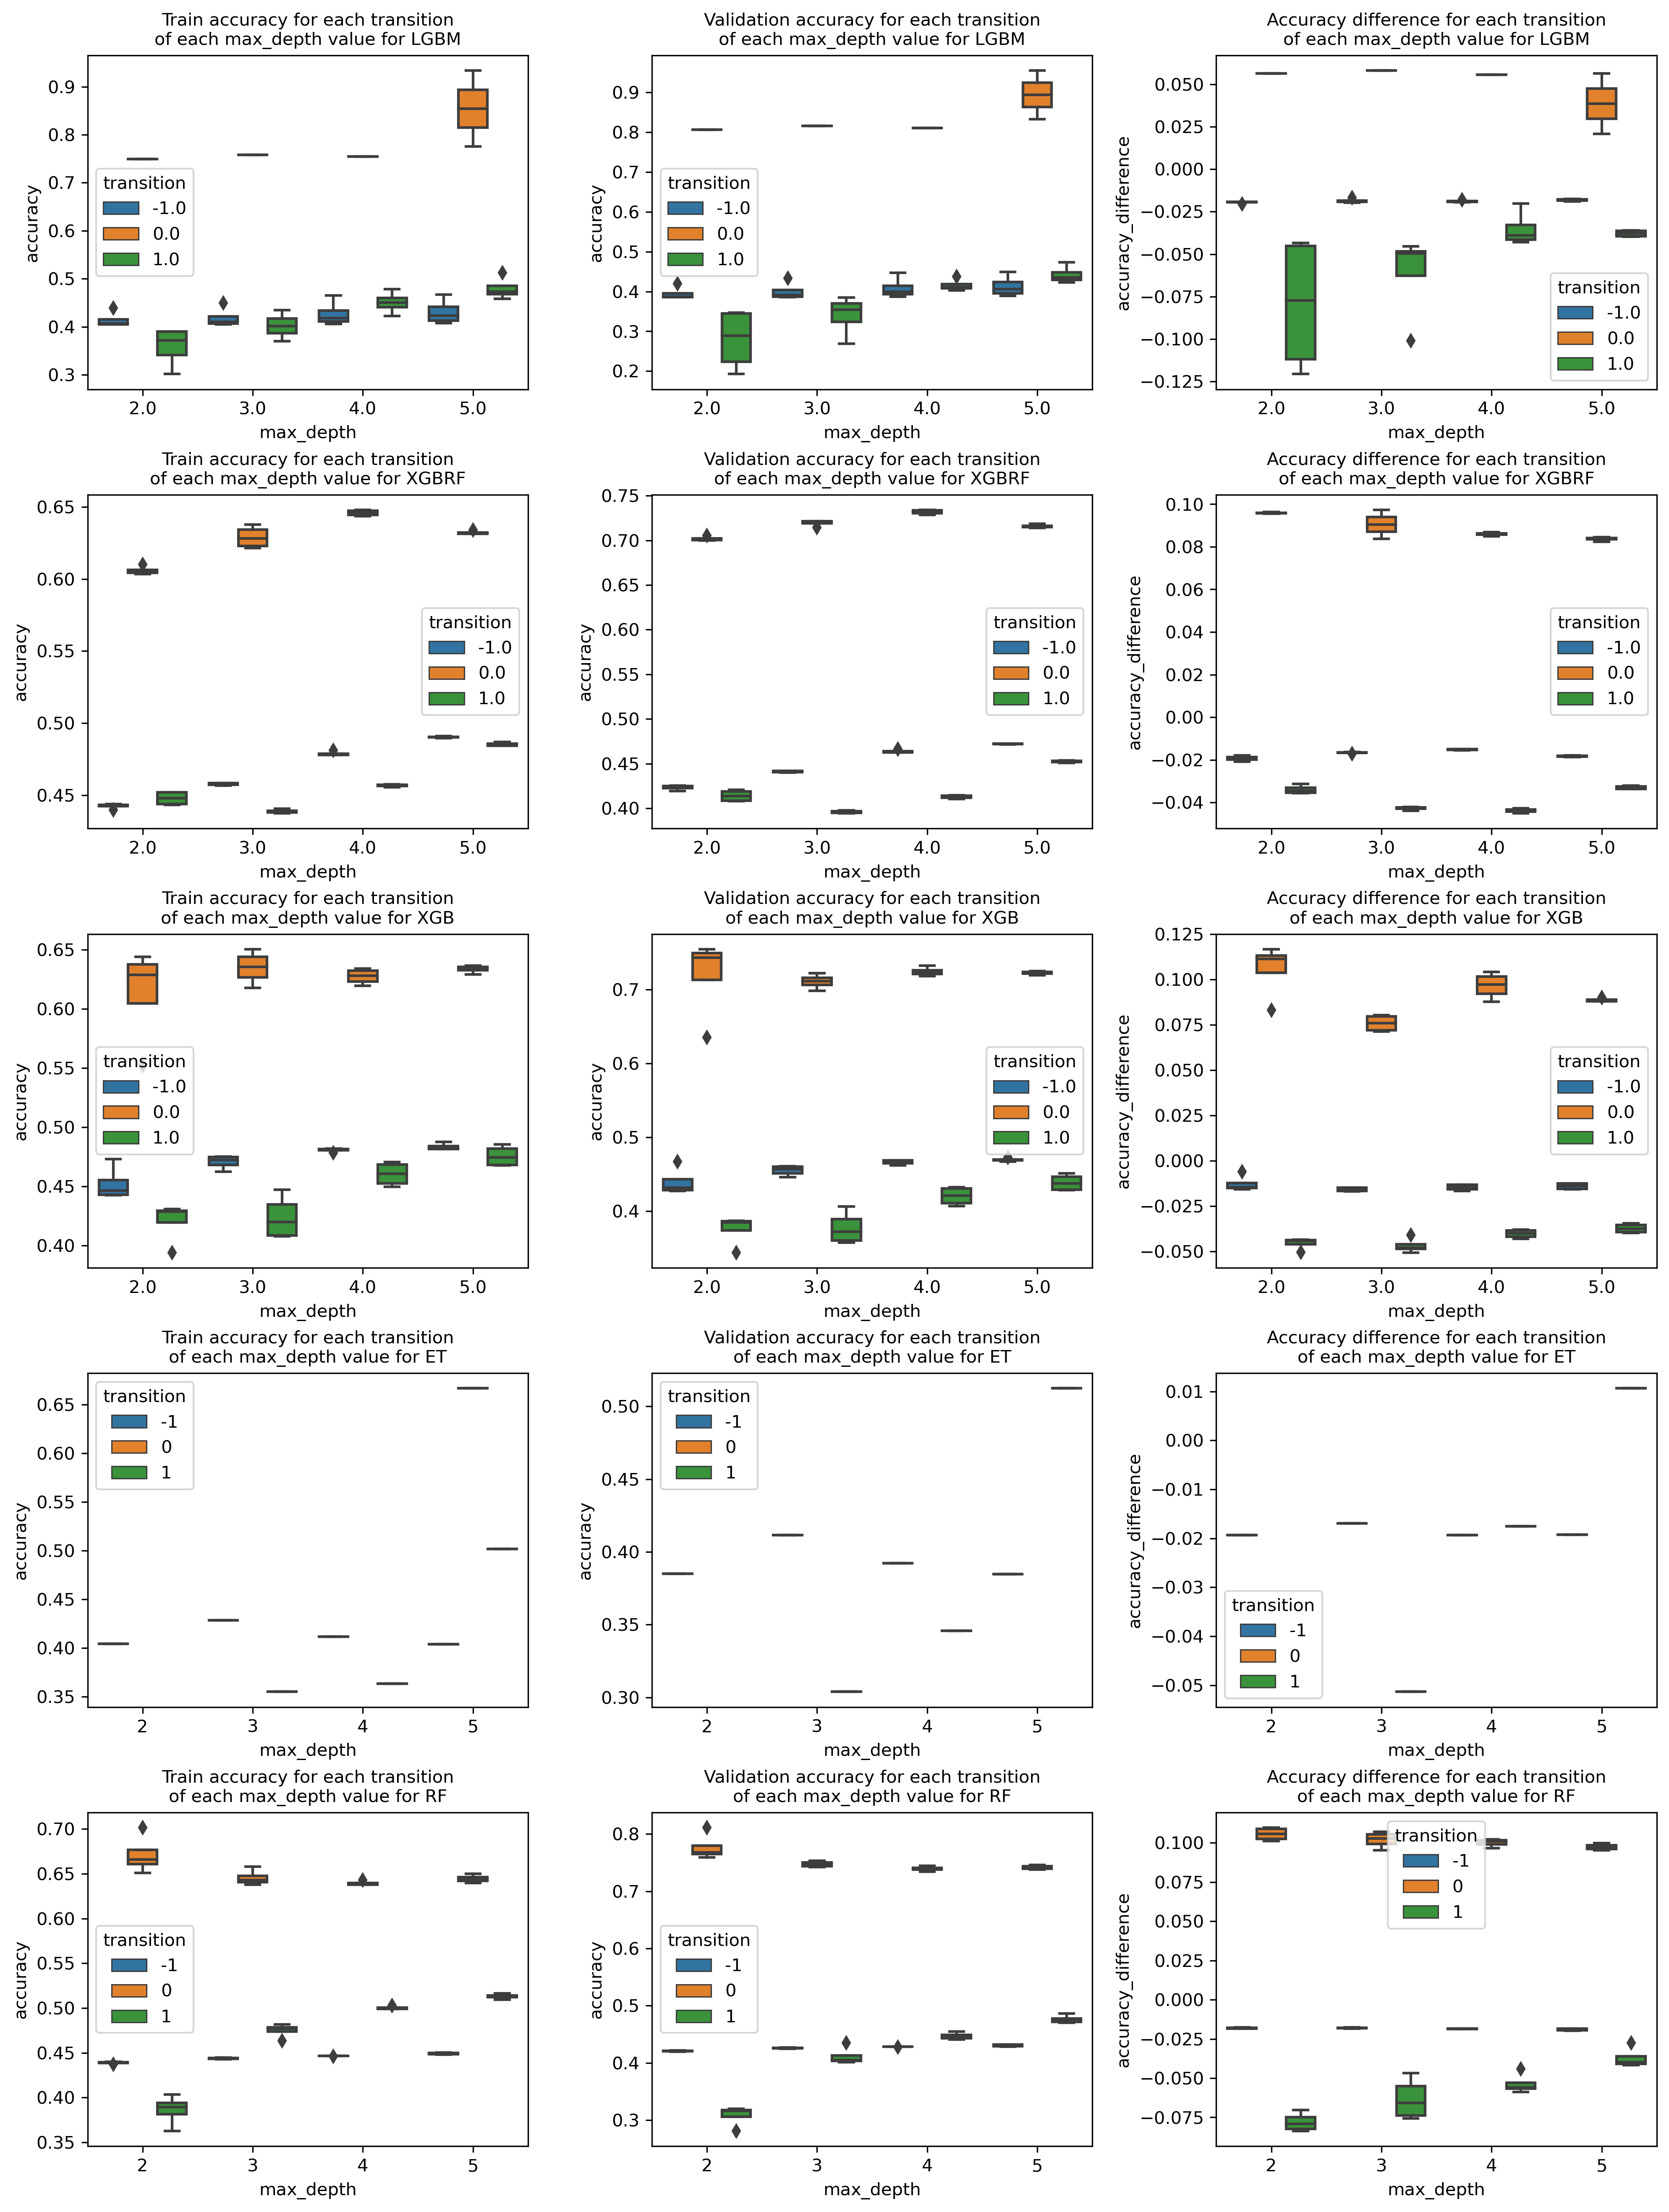

In [37]:

titles = ['Train accuracy for each transition\nof each max_depth value',
          'Validation accuracy for each transition\nof each max_depth value',
          'Accuracy difference for each transition\nof each max_depth value']

y_labels = ['accuracy', 'accuracy', 'accuracy_difference']
rem_methods = ['LGBM', 'XGBRF', 'XGB', 'ET', 'RF']

fig, axes = plt.subplots(nrows=len(rem_methods), ncols=3, figsize=(14, 18), dpi=300)

fig.tight_layout(pad=4.0)

for row in range(len(rem_methods)):
    for col in range(3):
        rem_method = rem_methods[row]
        
        if col==1: rem_set = 'validation'
        else: rem_set = 'train'
        
        if col==2: data = train_accuracy_df.query('method == @rem_method')
        else: data = model_results_df.query('method == @rem_method').query('set==@rem_set')
        
        axes[row][col].set_title(titles[col] + ' for ' + rem_methods[row], fontsize=10)
        seaborn.boxplot(ax=axes[row][col], x='max_depth', y=y_labels[col], hue='transition', data=data)
        
plt.show()


#### Conclusions
* The accuracy of all +1 transitions - except for ET and XGBRF models - increase with max_depth for all models and start to taper off at a max_depth of 5. <br>
* For LGBM and XGB models, the moderate variation in accuracies indicate a possible dependence on n_estimators. <br>
* For XGBRF, and RF models, the negligible variation in accuracies indicate little to no dependence on n_estimators. <br>
* ET model with a max_depth of 5 has the highest accuracy for +1 transitions. <br>
* At a max_depth of 5, LGBM models have an overall lower accuracy difference. <br>

Based on this information, the following should happen:
* The max_depth for the remaining model types should be >= 5. <br>
* ET with a max_depth of 5 is currently our best model for non-zero transitions; it will be used as the current benchmark even though it does not predict 0 transitions well. <br>
* The LGBM, XGB, and XGBRF model types should be further explored with respect to their hyperparameters - ET has no other significant parameters and LGBM seems to slightly outperform RF (choosing one of either to further explore would also be fine).

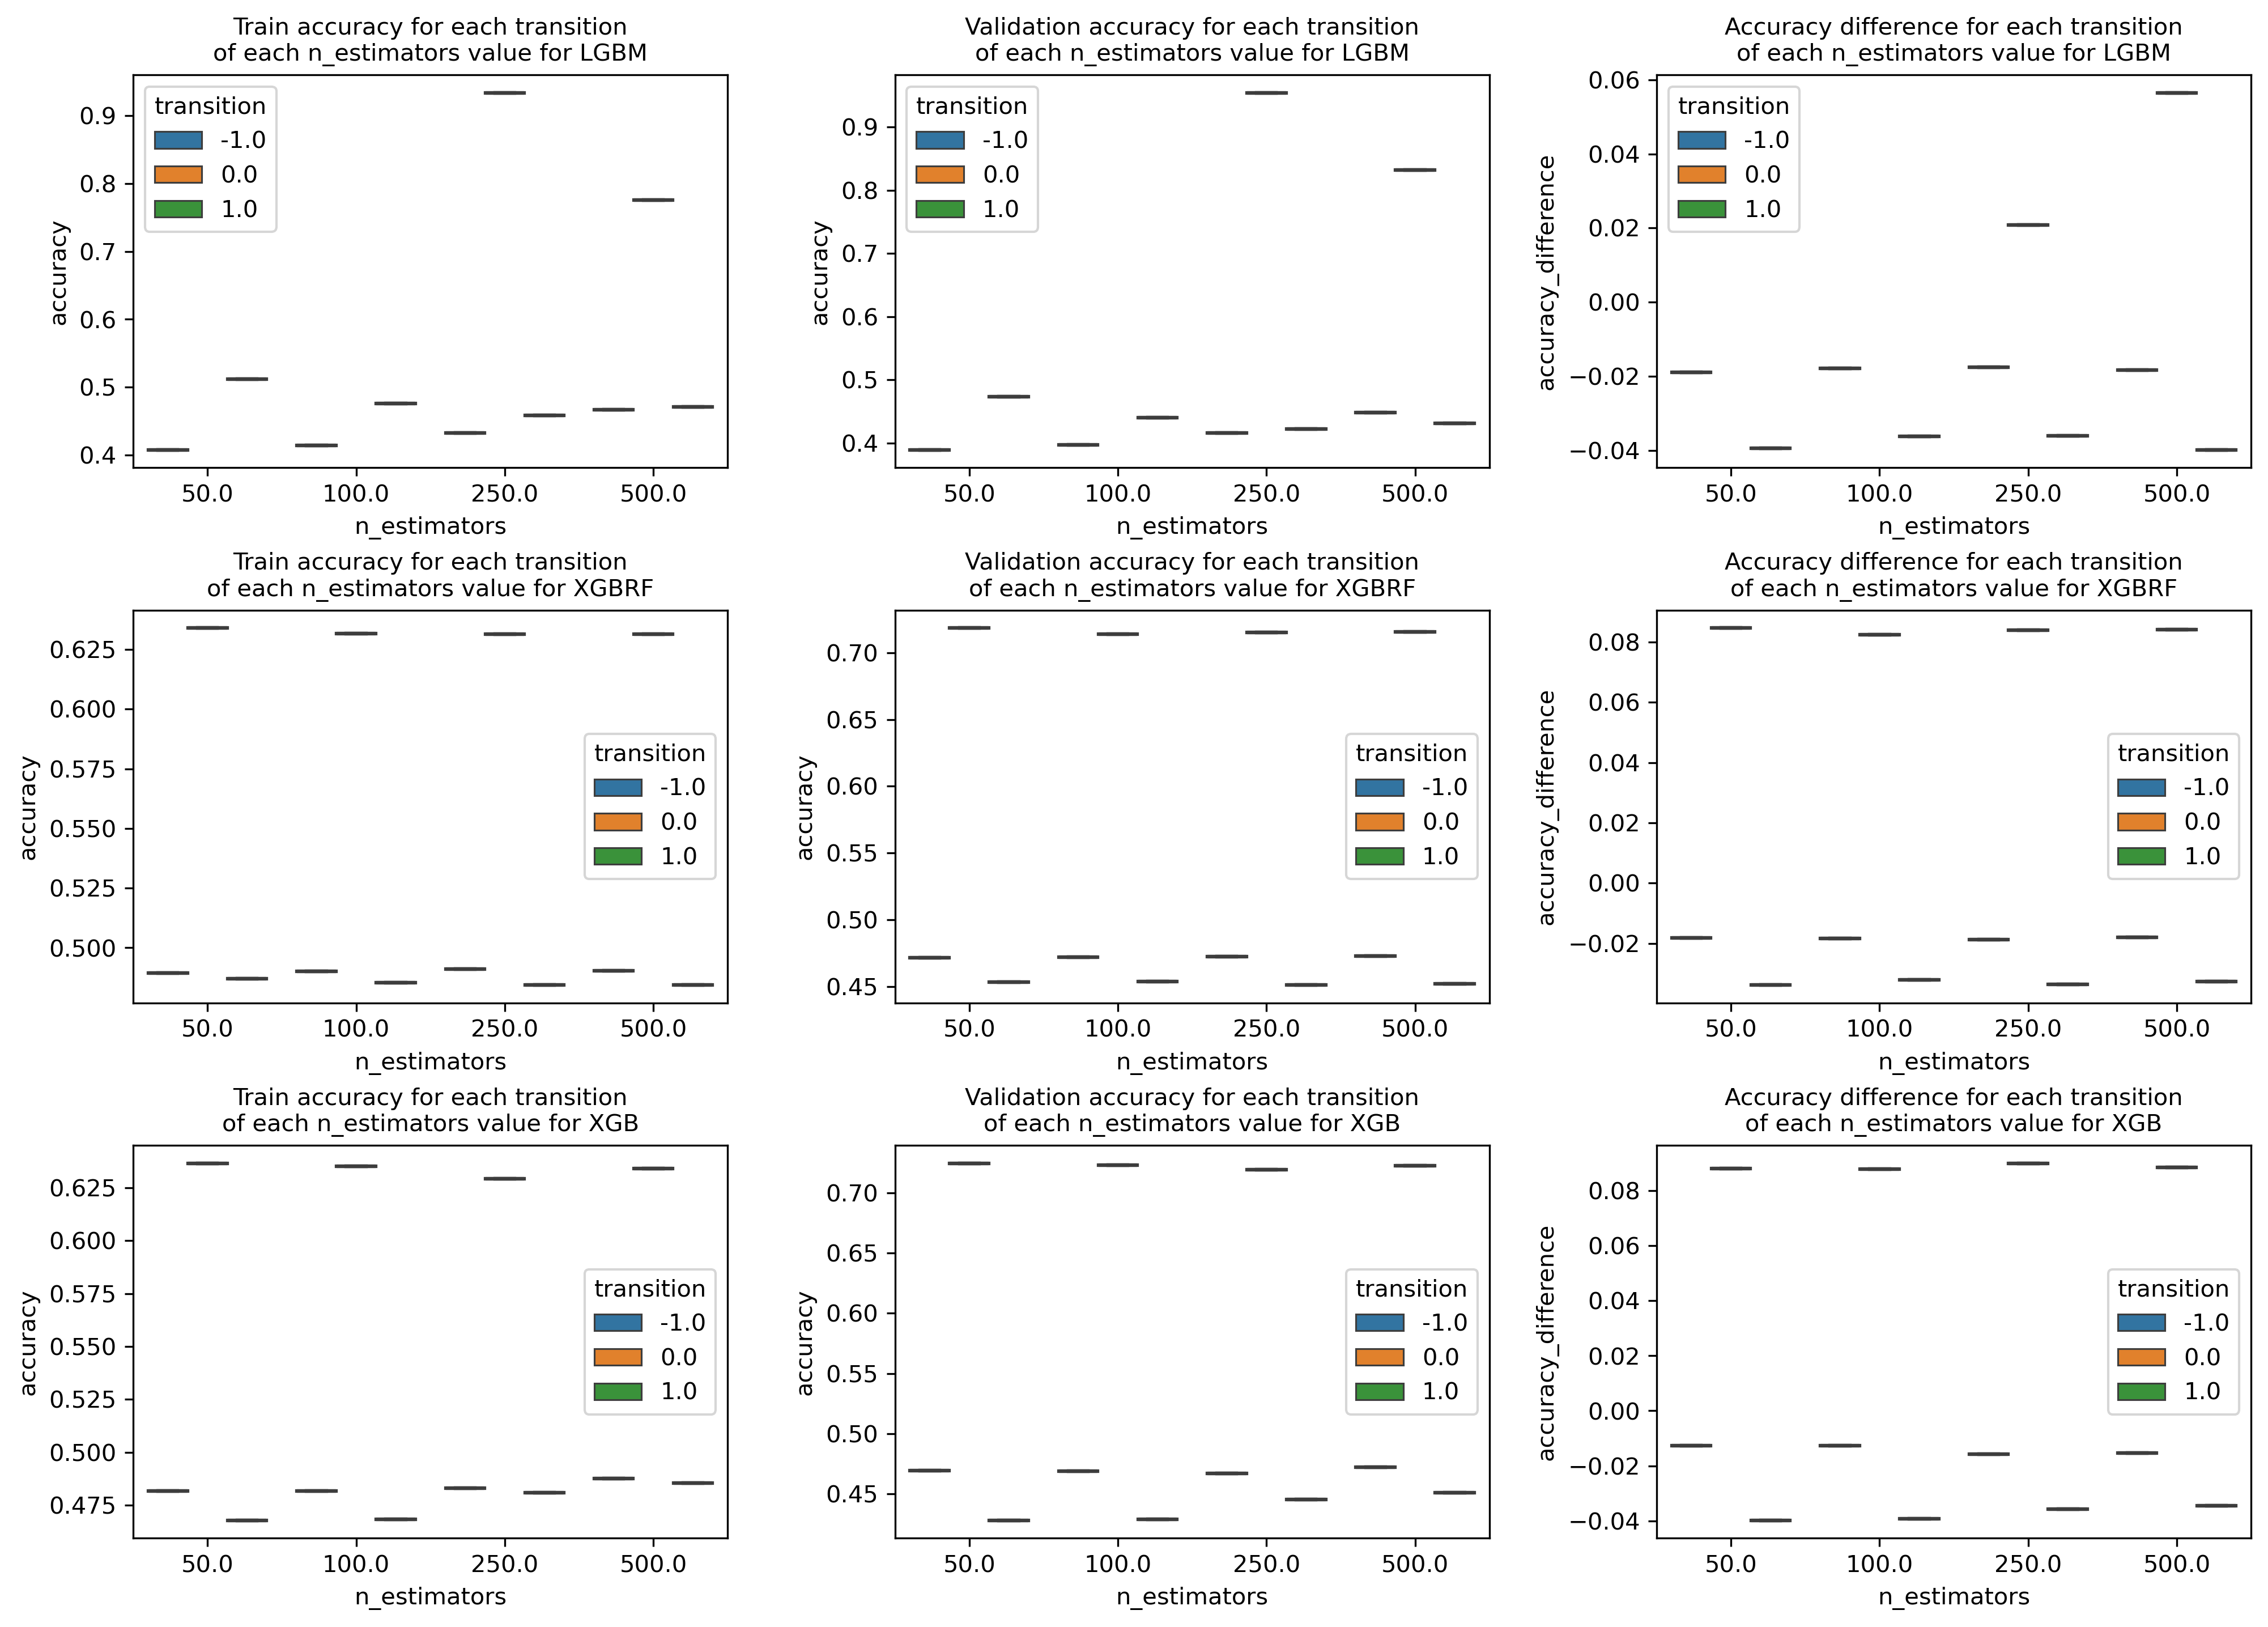

In [38]:

titles = ['Train accuracy for each transition\nof each n_estimators value',
          'Validation accuracy for each transition\nof each n_estimators value',
          'Accuracy difference for each transition\nof each n_estimators value']

y_labels = ['accuracy', 'accuracy', 'accuracy_difference']
rem_methods = ['LGBM', 'XGBRF', 'XGB']
comparisons = ['>=', '>=', '>=']
min_max_depths = [5, 5, 5]

fig, axes = plt.subplots(nrows=len(rem_methods), ncols=3, figsize=(14, 10), dpi=300)

fig.tight_layout(pad=4.0)

for row in range(len(rem_methods)):
    for col in range(3):
        rem_method = rem_methods[row]
        min_max_depth = min_max_depths[row]
        
        if col==1: rem_set = 'validation'
        else: rem_set = 'train'
        
        if col==2: data = train_accuracy_df.query('method == @rem_method')
        else: data = model_results_df.query('method == @rem_method').query('set == @rem_set')
        
        data = data.query(f'max_depth {comparisons[row]} @min_max_depth')
        
        axes[row][col].set_title(titles[col] + ' for ' + rem_methods[row], fontsize=10)
        seaborn.boxplot(ax=axes[row][col], x='n_estimators', y=y_labels[col], hue='transition', data=data)
        
plt.show()


In [39]:

model_results_df[model_results_df['accuracy'].isna()]


transition      loss accuracy parameter_set max_depth n_estimators  \
1         0.0  1.047641      NaN           0.0       2.0         50.0   
4         0.0  1.040225      NaN           1.0       2.0        100.0   
7         0.0  1.021672      NaN           2.0       2.0        250.0   
13        0.0  1.045574      NaN           4.0       3.0         50.0   
16        0.0  1.036416      NaN           5.0       3.0        100.0   
19        0.0  1.013797      NaN           6.0       3.0        250.0   
25        0.0  1.044191      NaN           8.0       4.0         50.0   
28        0.0  1.033723      NaN           9.0       4.0        100.0   
31        0.0   1.00757      NaN          10.0       4.0        250.0   
37        0.0  1.043137      NaN          12.0       5.0         50.0   
40        0.0  1.031655      NaN          13.0       5.0        100.0   
1         0.0  1.082985      NaN           0.0       2.0         50.0   
4         0.0  1.074807      NaN           1.0       2.0        100.0   
7         0.0  1.054105      NaN           2.0       2.0        250.0   
13        0.0  1.080529      NaN           4.0       3.0         50.0   
16        0.0  1.070338      NaN           5.0       3.0        100.0   
19        0.0  1.045178      NaN           6.0       3.0        250.0   
25        0.0  1.078906      NaN           8.0       4.0         50.0   
28        0.0  1.067186      NaN           9.0       4.0        100.0   
31        0.0  1.037812      NaN          10.0       4.0        250.0   
37        0.0  1.077698      NaN          12.0       5.0         50.0   
40        0.0   1.06473      NaN          13.0       5.0        100.0   
2           1  0.970731      NaN           0.0         2         None   
2           1   1.00346      NaN           0.0         2         None   
1           0  1.044185      NaN           0.0         2         None   
2           1  1.044185      NaN           0.0         2         None   
4           0  1.019842      NaN           1.0         3         None   
7           0  1.031788      NaN           2.0         4         None   
1           0  1.067958      NaN           0.0         2         None   
2           1  1.067958      NaN           0.0         2         None   
4           0  1.045124      NaN           1.0         3         None   
7           0  1.053876      NaN           2.0         4         None   
10          0  1.076529      NaN           3.0         5         None   
1           0  1.033476      NaN           0.0         2         None   
4           0   1.02824      NaN           1.0         3         None   
7           0  1.024205      NaN           2.0         4         None   
10          0  1.021295      NaN           3.0         5         None   
1           0  1.067323      NaN           0.0         2         None   
4           0  1.061264      NaN           1.0         3         None   
7           0  1.056596      NaN           2.0         4         None   
10          0  1.052989      NaN           3.0         5         None   

   learning_rate         set method  
1          0.001       train   LGBM  
4          0.001       train   LGBM  
7          0.001       train   LGBM  
13         0.001       train   LGBM  
16         0.001       train   LGBM  
19         0.001       train   LGBM  
25         0.001       train   LGBM  
28         0.001       train   LGBM  
31         0.001       train   LGBM  
37         0.001       train   LGBM  
40         0.001       train   LGBM  
1          0.001  validation   LGBM  
4          0.001  validation   LGBM  
7          0.001  validation   LGBM  
13         0.001  validation   LGBM  
16         0.001  validation   LGBM  
19         0.001  validation   LGBM  
25         0.001  validation   LGBM  
28         0.001  validation   LGBM  
31         0.001  validation   LGBM  
37         0.001  validation   LGBM  
40         0.001  validation   LGBM  
2           None       train     DT  
2           None  valida

#### Conclusions
* n_estimators doesn't seem to have a significant effect on the accuracy of XGB and XGBRF model types. <br>
* for LGBM models, it seems that the two models with the most n_estimators are the only two that give any 0 transition predictions. <br>
* for LGBM models, it looks like +1 prediction accuracy decreases with increasing number of estimators, this suggests that the models with less estimators are more biased. <br>
* XGB and XGBRF models don't seem to have any of those issues with predictions.

Based on this information the sample space for n_estimators should be fixed to 50 and LGBM models should be further excluded from exploration.

In [40]:

# all_params.extend([...]) # add new parameters depending on what models you have left

model_types = {'XGBRF':XGBRFClassifier, 'XGB':XGBClassifier}
model_params = {'XGB':get_argument_sets([],{'max_depth':[5,6,7,8], 'n_estimators':[50],
                                            'learning_rate':learning_rate, 'n_jobs':n_jobs}),
                'XGBRF':get_argument_sets([],{'max_depth':[5,6,7,8], 'n_estimators':[50],
                                              'learning_rate':learning_rate, 'n_jobs':n_jobs})}

models, model_results = train_models(model_types, model_params, all_params, x_train, y_train, x_vali, y_vali, False)


In [41]:

model_results_df = pack_results(all_params, model_results)

model_results_df['max_depth'].fillna(0, inplace=True)

model_results_df


Hyperparameter combinations per model type
XGBRF    4
XGB      4
Name: method, dtype: int64


transition      loss  accuracy  parameter_set  max_depth  n_estimators  \
0         -1.0  1.098391  0.489539            0.0        5.0          50.0   
1          0.0  1.098391  0.633969            0.0        5.0          50.0   
2          1.0  1.098391  0.487038            0.0        5.0          50.0   
3         -1.0  1.098376  0.495657            1.0        6.0          50.0   
4          0.0  1.098376  0.637090            1.0        6.0          50.0   
5          1.0  1.098376  0.493766            1.0        6.0          50.0   
6         -1.0  1.098364  0.498531            2.0        7.0          50.0   
7          0.0  1.098364  0.641147            2.0        7.0          50.0   
8          1.0  1.098364  0.500804            2.0        7.0          50.0   
9         -1.0  1.098353  0.502976            3.0        8.0          50.0   
10         0.0  1.098353  0.641718            3.0        8.0          50.0   
11         1.0  1.098353  0.508829            3.0        8.0          50.0   
0         -1.0  1.098392  0.471393            0.0        5.0          50.0   
1          0.0  1.098392  0.718568            0.0        5.0          50.0   
2          1.0  1.098392  0.453257            0.0        5.0          50.0   
3         -1.0  1.098377  0.476801            1.0        6.0          50.0   
4          0.0  1.098377  0.721101            1.0        6.0          50.0   
5          1.0  1.098377  0.459882            1.0        6.0          50.0   
6         -1.0  1.098364  0.477948            2.0        7.0          50.0   
7          0.0  1.098364  0.727073            2.0        7.0          50.0   
8          1.0  1.098364  0.466981            2.0        7.0          50.0   
9         -1.0  1.098353  0.479955            3.0        8.0          50.0   
10         0.0  1.098353  0.725328            3.0        8.0          50.0   
11         1.0  1.098353  0.472388            3.0        8.0          50.0   
0         -1.0  1.087688  0.481802            0.0        5.0          50.0   
1          0.0  1.087688  0.636596            0.0        5.0          50.0   
2          1.0  1.087688  0.467867            0.0        5.0          50.0   
3         -1.0  1.086888  0.489317            1.0        6.0          50.0   
4          0.0  1.086888  0.636690            1.0        6.0          50.0   
5          1.0  1.086888  0.485833            1.0        6.0          50.0   
6         -1.0  1.086338  0.495811            2.0        7.0          50.0   
7          0.0  1.086338  0.634797            2.0        7.0          50.0   
8          1.0  1.086338  0.492286            2.0        7.0          50.0   
9         -1.0  1.085911  0.497394            3.0        8.0          50.0   
10         0.0  1.085911  0.636169            3.0        8.0          50.0   
11         1.0  1.085911  0.502093            3.0        8.0          50.0   
0         -1.0  1.087814  0.469187            0.0        5.0          50.0   
1          0.0  1.087814  0.724706            0.0        5.0          50.0   
2          1.0  1.087814  0.428050            0.0        5.0          50.0   
3         -1.0  1.086935  0.470007            1.0        6.0          50.0   
4          0.0  1.086935  0.724053            1.0        6.0          50.0   
5          1.0  1.086935  0.452033            1.0        6.0          50.0   
6         -1.0  1.086407  0.474868            2.0        7.0          50.0   
7          0.0  1.086407  0.726089            2.0        7.0          50.0   
8          1.0  1.086407  0.457837            2.0        7.0          50.0   
9         -1.0  1.085937  0.475437            3.0        8.0          50.0   
10         0.0  1.085937  0.722402            3.0        8.0          50.0   
11         1.0  1.085937  0.465854            3.0        8.0          50.0   

    learning_rate         set method  
0           0.001       train  XGBRF  
1           0.001       train  XGBRF  
2           0.001       train  XGBRF  
3           0.001       t

In [42]:

train_accuracy_df = model_results_df.query('set=="train"')
vali_accuracy_df = model_results_df.query('set=="validation"')

train_accuracy_df.sort_values(['parameter_set', 'transition'], inplace=True)
vali_accuracy_df.sort_values(['parameter_set', 'transition'], inplace=True)

train_accuracy_df.reset_index(inplace=True)
vali_accuracy_df.reset_index(inplace=True)

train_accuracy_df['accuracy_difference'] = vali_accuracy_df['accuracy'] - train_accuracy_df['accuracy']


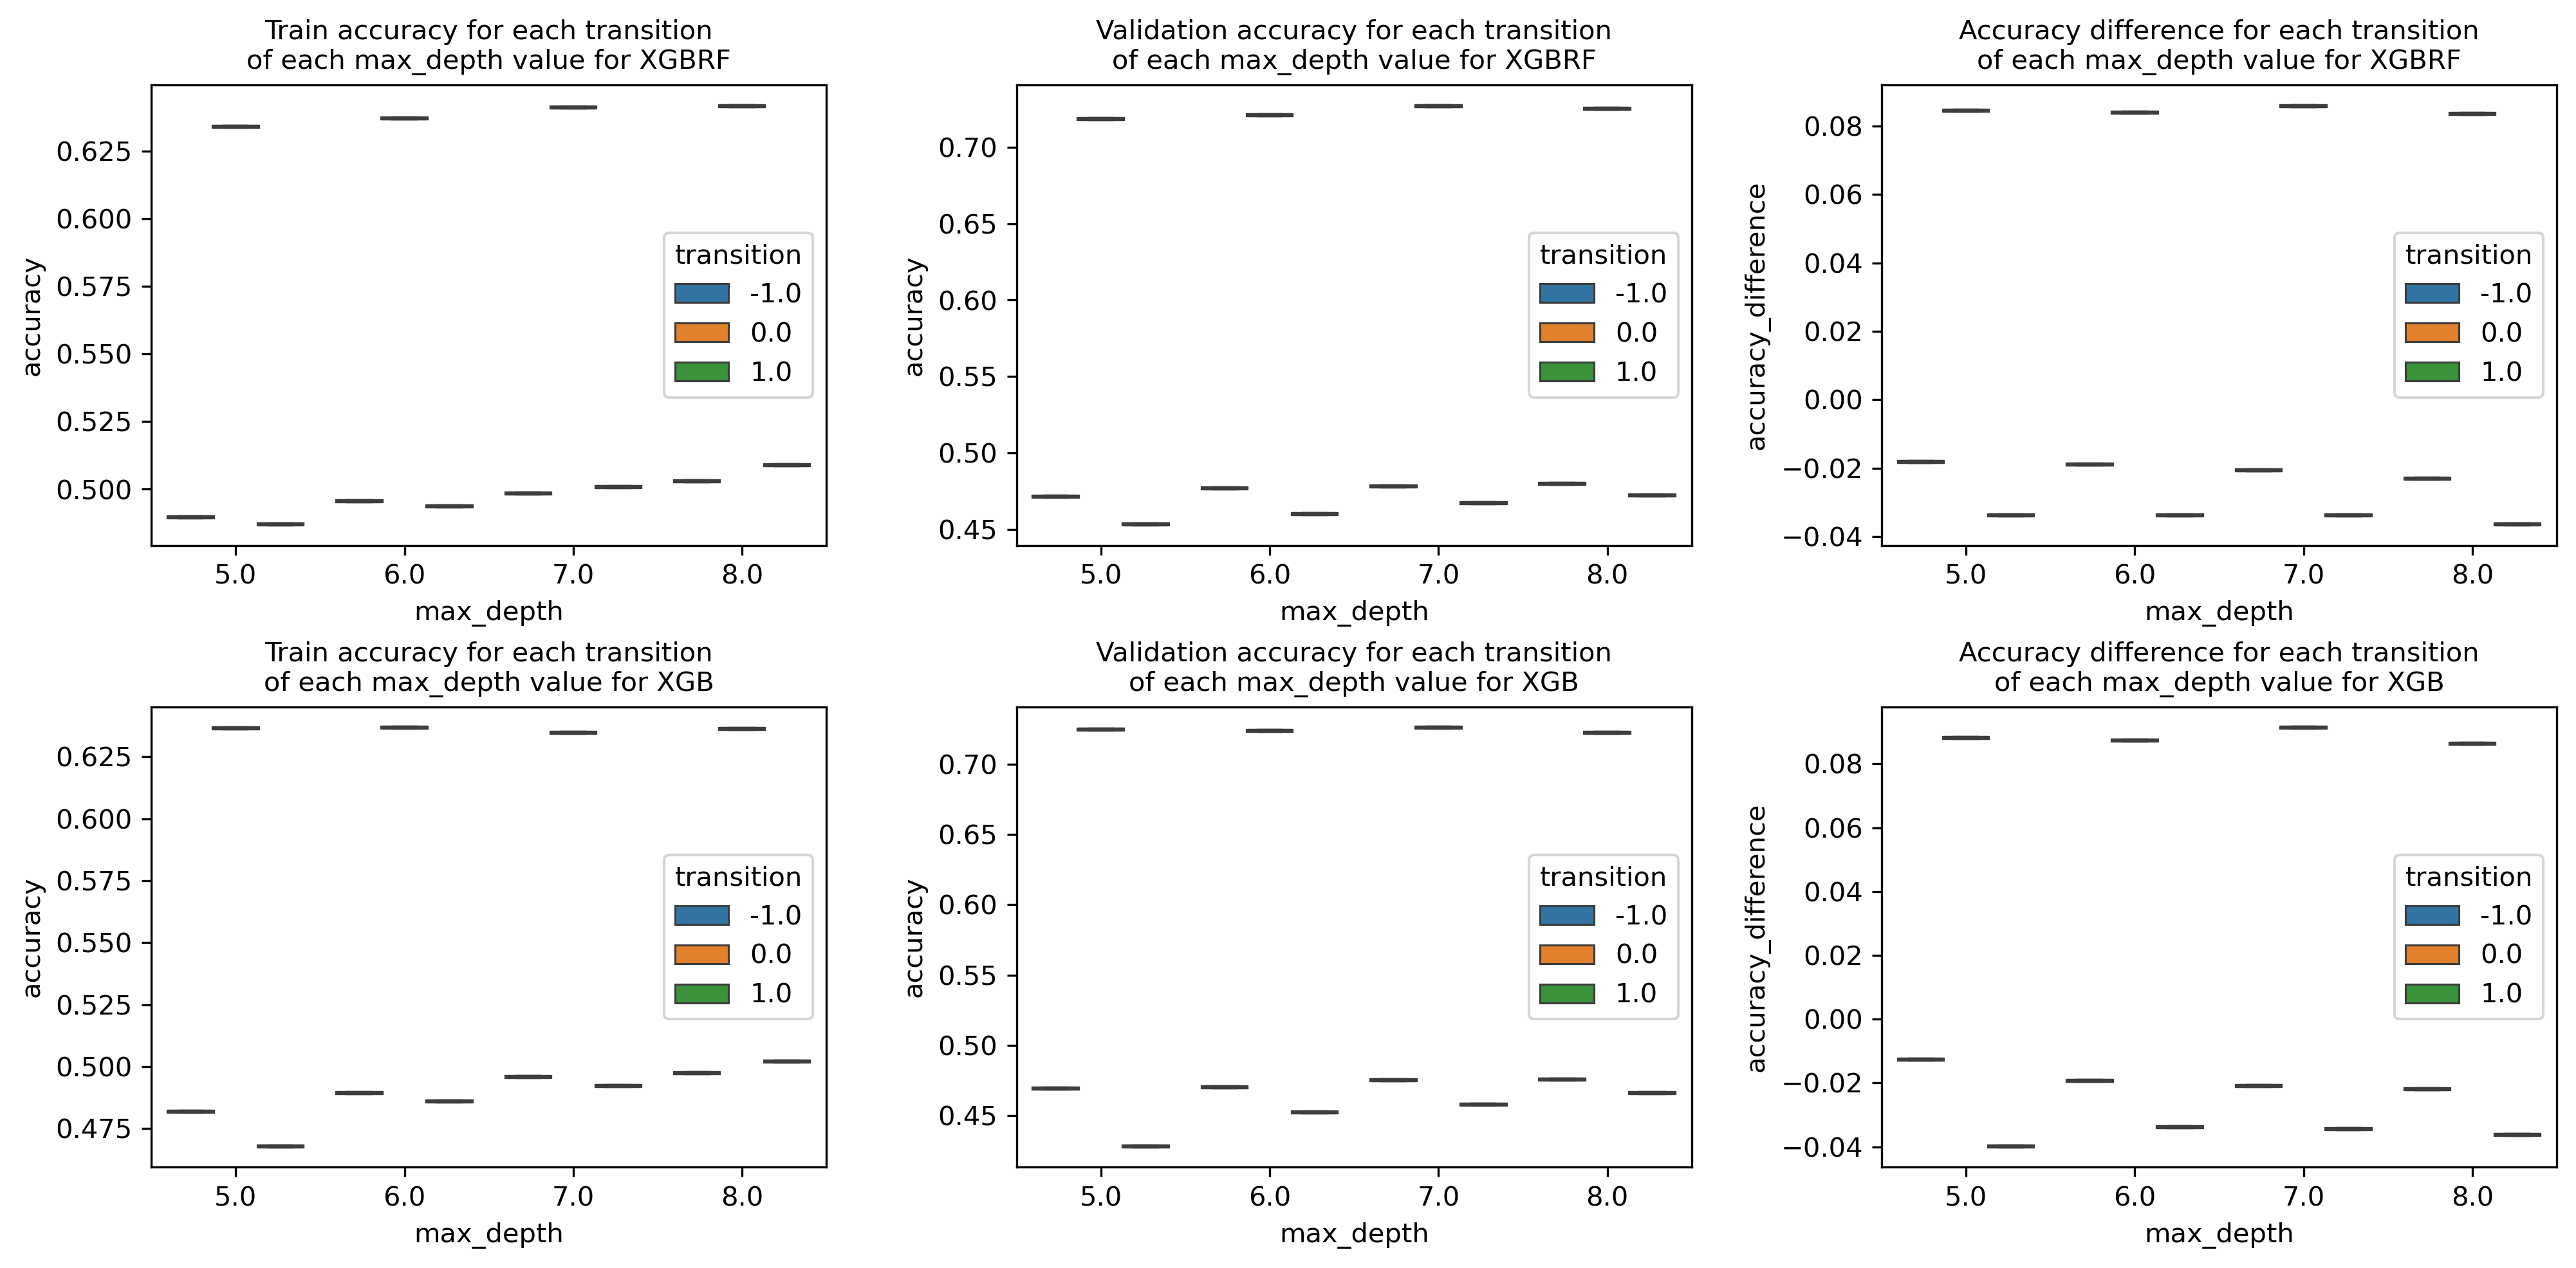

In [43]:

titles = ['Train accuracy for each transition\nof each max_depth value',
          'Validation accuracy for each transition\nof each max_depth value',
          'Accuracy difference for each transition\nof each max_depth value']

y_labels = ['accuracy', 'accuracy', 'accuracy_difference']
rem_methods = ['XGBRF', 'XGB']

fig, axes = plt.subplots(nrows=len(rem_methods), ncols=3, figsize=(14, 7), dpi=300)

fig.tight_layout(pad=4.0)

for row in range(len(rem_methods)):
    for col in range(3):
        rem_method = rem_methods[row]
        
        if col==1: rem_set = 'validation'
        else: rem_set = 'train'
        
        if col==2: data = train_accuracy_df.query('method == @rem_method')
        else: data = model_results_df.query('method == @rem_method').query('set==@rem_set')
        
        axes[row][col].set_title(titles[col] + ' for ' + rem_methods[row], fontsize=10)
        seaborn.boxplot(ax=axes[row][col], x='max_depth', y=y_labels[col], hue='transition', data=data)
        
plt.show()


#### Conclusions
* For both models, a max_depth of 8 appears to best balance the accuracy and accuracy differences of all transitions. <br>
* Even though ET models have shown higher accuracy for +1 transitions, XGB and XGBRF models have shown to be much more stable. <br>

Since there are no other significant hyperparameters to address, the computation speed will decide the better model between XGB and XGBRF.


In [44]:

xgb = models['XGB'][3]
xgbrf = models['XGBRF'][3]

%time for i in range(10000): xgb.predict(x_train.iloc[:1])
%time for i in range(10000): xgbrf.predict(x_train.iloc[:1])


Wall time: 17.7 s
Wall time: 18.1 s


### Chose the better model

XGB will be the final model.


In [45]:

final_xgb_results = model_results_df.query('n_estimators == 50').query('method == "XGB"').query('max_depth == 8')

final_xgb_results


transition      loss  accuracy  parameter_set  max_depth  n_estimators  \
9         -1.0  1.085911  0.497394            3.0        8.0          50.0   
10         0.0  1.085911  0.636169            3.0        8.0          50.0   
11         1.0  1.085911  0.502093            3.0        8.0          50.0   
9         -1.0  1.085937  0.475437            3.0        8.0          50.0   
10         0.0  1.085937  0.722402            3.0        8.0          50.0   
11         1.0  1.085937  0.465854            3.0        8.0          50.0   

    learning_rate         set method  
9           0.001       train    XGB  
10          0.001       train    XGB  
11          0.001       train    XGB  
9           0.001  validation    XGB  
10          0.001  validation    XGB  
11          0.001  validation    XGB

In [46]:

final_model_results = [i for i in model_results['XGB'] if i['max_depth']==8 and i['n_estimators']==50]
final_model_index = model_results['XGB'].index([i for i in final_model_results][0])
final_model = models['XGB'][final_model_index]


### Compare feature importances

In [47]:

final_features = {features[i]:final_model.feature_importances_[i] for i in range(len(features))}
ordered_features = []

for feature in reversed(sorted(list(final_features), key = lambda feature : final_features[feature])):
    print(feature, final_features[feature])
    
    ordered_features.append(feature)
    

time_of_day 0.40067503
relative_volume 0.34130293
n 0.112783134
mean 0.04475633
dp 0.043872193
std 0.023990333
dt 0.0056423983
vsum 0.0052627535
average_volume 0.0046120314
previous_days_close 0.0037214358
rolling_csum 0.0028841817
rolling_vsum 0.0025564742
p(-dx) 0.0024616804
size 0.0022476476
p(+dx) 0.0017971926
lambda 0.0014341782


#### Conclusions
Based on the feature importances, there are 6 features that carry the vast majority of importance. The final model will be retrained and evaluated with those 6 features and then the top 3 features since they carry the most importance.


Number of features : 6
Train loss : 1.085931616251543
Validation loss : 1.0859394226622074


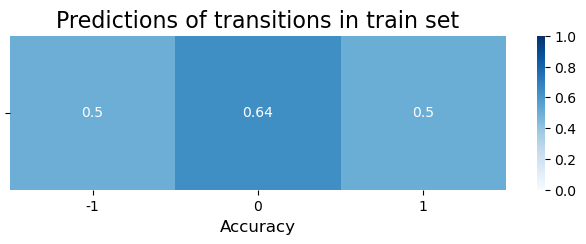

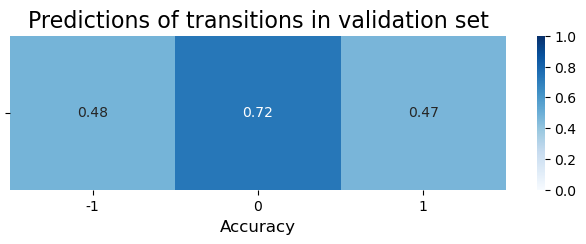

Number of features : 3
Train loss : 1.0866689437114387
Validation loss : 1.0867420881249554


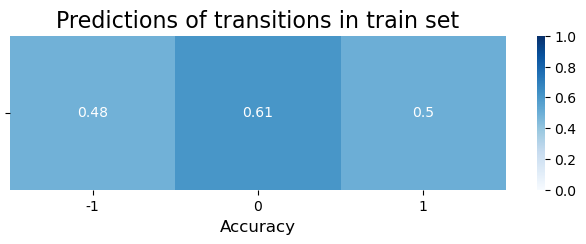

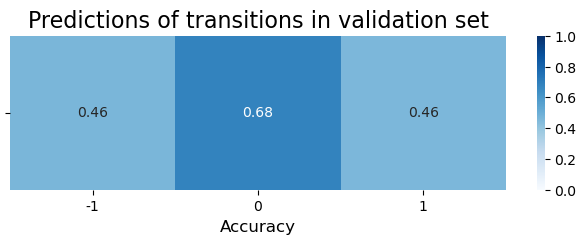

In [48]:

final_models = {}
top_num_features = [6, 3]

for num_features in top_num_features:
    
    print('Number of features :', num_features)
    
    final_model = final_model.__class__(**final_model.get_params()).fit(x_train[ordered_features[:num_features]], y_train+1)
    
    print('Train loss :', log_loss(y_train, final_model.predict_proba(x_train[ordered_features[:num_features]])))
    print('Validation loss :', log_loss(y_vali, final_model.predict_proba(x_vali[ordered_features[:num_features]])))
    
    plot_sample(get_accuracy(y_train, final_model.predict(x_train[ordered_features[:num_features]])-1),
                'Predictions of transitions in train set', 'Accuracy', 'Blues')

    plot_sample(get_accuracy(y_vali, final_model.predict(x_vali[ordered_features[:num_features]])-1),
                'Predictions of transitions in validation set', 'Accuracy', 'Blues')
    
    final_models[num_features] = final_model
    

#### Conclusions
The final model will only use the top 3 features. <br>

Now we will train a neural net and compare it with our current final model. <br>
It will be a standard feed foward neural network (I'm only showing the final, tuned model) and trained on all, the 6 most important, and the 3 most important features.

In [49]:

def relu(x): return tensorflow.keras.backend.relu(x, alpha=0.1) # leaky relu
def neg_log_loss(true, pred): # negative log loss
    
    eps = tensorflow.keras.backend.epsilon()
    r_sum = tensorflow.keras.backend.sum(true * tensorflow.keras.backend.log(eps + pred), axis=-1)
    
    return -tensorflow.keras.backend.mean(r_sum)

# one-hot-encoding and inverse one-hot-encoding
def y_ohe(y): return numpy.array(y[...,None] == numpy.array([[-1,0,1]])[None,...], dtype=numpy.float32)[0,...]
def y_iohe(y): return (y * numpy.array([-1,0,1])[None,...]).sum(axis=-1)

def multi_pred(model, x): # non-binary class prediction - class is the one with the highest probability
    
    mp = numpy.array(model.predict(x, verbose=0))
    
    return numpy.array(mp == numpy.array(mp.max(axis=-1)[...,None]), dtype=numpy.float32)

def construct_and_train_nn(x, y, ff_dim0, ff_dim1, iters): # construct a neural net
    
    inputs = tensorflow.keras.layers.Input((len(x.columns),))
    
    for i in range(iters):
        if i == 0:
            dense0 = tensorflow.keras.layers.Dense(ff_dim0, activation=relu)(inputs)
            dense1 = tensorflow.keras.layers.Dense(ff_dim1, activation=relu)(dense0)
            
            continue
            
        dense0 = tensorflow.keras.layers.Dense(ff_dim0, activation=relu)(dense1)
        dense1 = tensorflow.keras.layers.Dense(ff_dim1, activation=relu)(dense0) + dense1
        
    outputs = tensorflow.keras.layers.Dense(3, activation='softmax')(dense1)
    model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
    adam = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(optimizer=adam, loss=neg_log_loss, metrics=['accuracy'])
    model.fit(x, y, epochs=100, batch_size=256, verbose=0)
    
    return model


NUM_FEATURES = 16


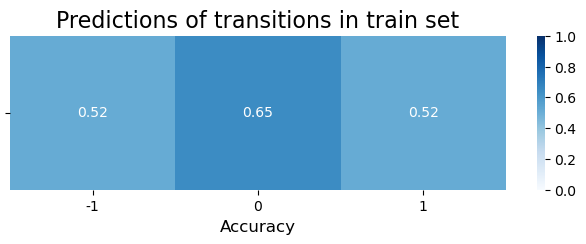

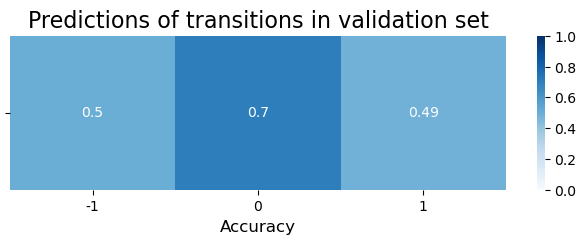

NUM_FEATURES = 6


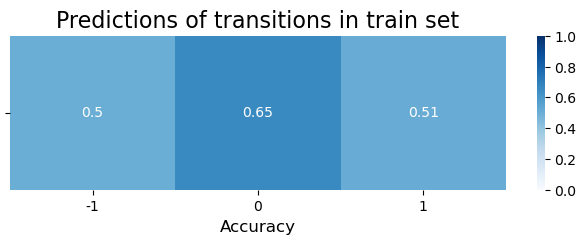

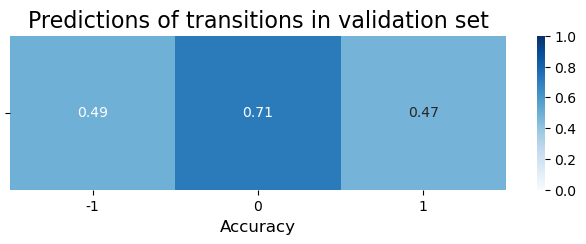

NUM_FEATURES = 3


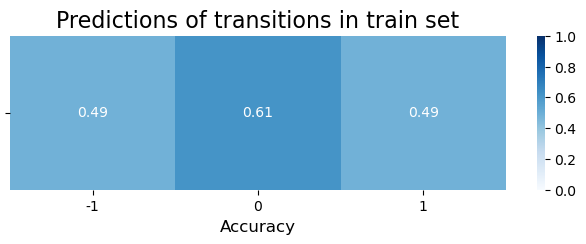

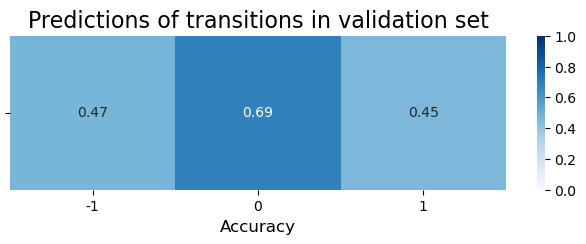

In [50]:

neural_nets = {}

for num_features in [len(x_train.columns)] + top_num_features:
    model = construct_and_train_nn(x_train[ordered_features[:num_features]], y_ohe(y_train), 32, 16, 3)
    neural_nets[num_features] = model
    
    print('NUM_FEATURES =', num_features)
    
    plot_sample(get_accuracy(y_train, y_iohe(multi_pred(model, x_train[ordered_features[:num_features]]))),
                'Predictions of transitions in train set', 'Accuracy', 'Blues')
    
    plot_sample(get_accuracy(y_vali, y_iohe(multi_pred(model, x_vali[ordered_features[:num_features]]))),
                'Predictions of transitions in validation set', 'Accuracy', 'Blues')
    

#### Conclusions
Based on the accuracies, there doesn't seem to be a significant difference between all and the most important 10 features. The accuracy of the model trained with 3 features seems to have a slight decrease in accuracy. <br>

Now we will compare the parity of the probability predictions of our final XGB model and our neural nets (Example : if a model predicts that there is a 50% chance that a set of transitions are +1, we expect that 50% of those transitions are actually +1 transitions). Models with better parity plots will allow us to be more selective in the trades that we take for whatever strategy we will execute. <br>


In [51]:

# group predictions by their chance of being correct for each possible true value
# x ~ average probability for all predictions near x
# y = accuracy of predictions with predicted probability near x for each possible true value
# shape for y = (number of possible true values, points)

def get_parity(trues, preds, points):
    
    min_proba = preds.min()
    max_proba = preds.max()
    
    indices = ((points - 1) * (preds - min_proba) / (max_proba - min_proba)) // 1
    
    x = min_proba + (max_proba - min_proba) * numpy.arange(points) / (points - 1)
    y = numpy.concatenate([((trues * (indices==index)).sum(axis=0) / (indices==index).sum(
        axis=0))[:,None] for index in range(points)], axis=-1)
    
    return x, y


4075/4075 [==============================] - 4s 980us/step


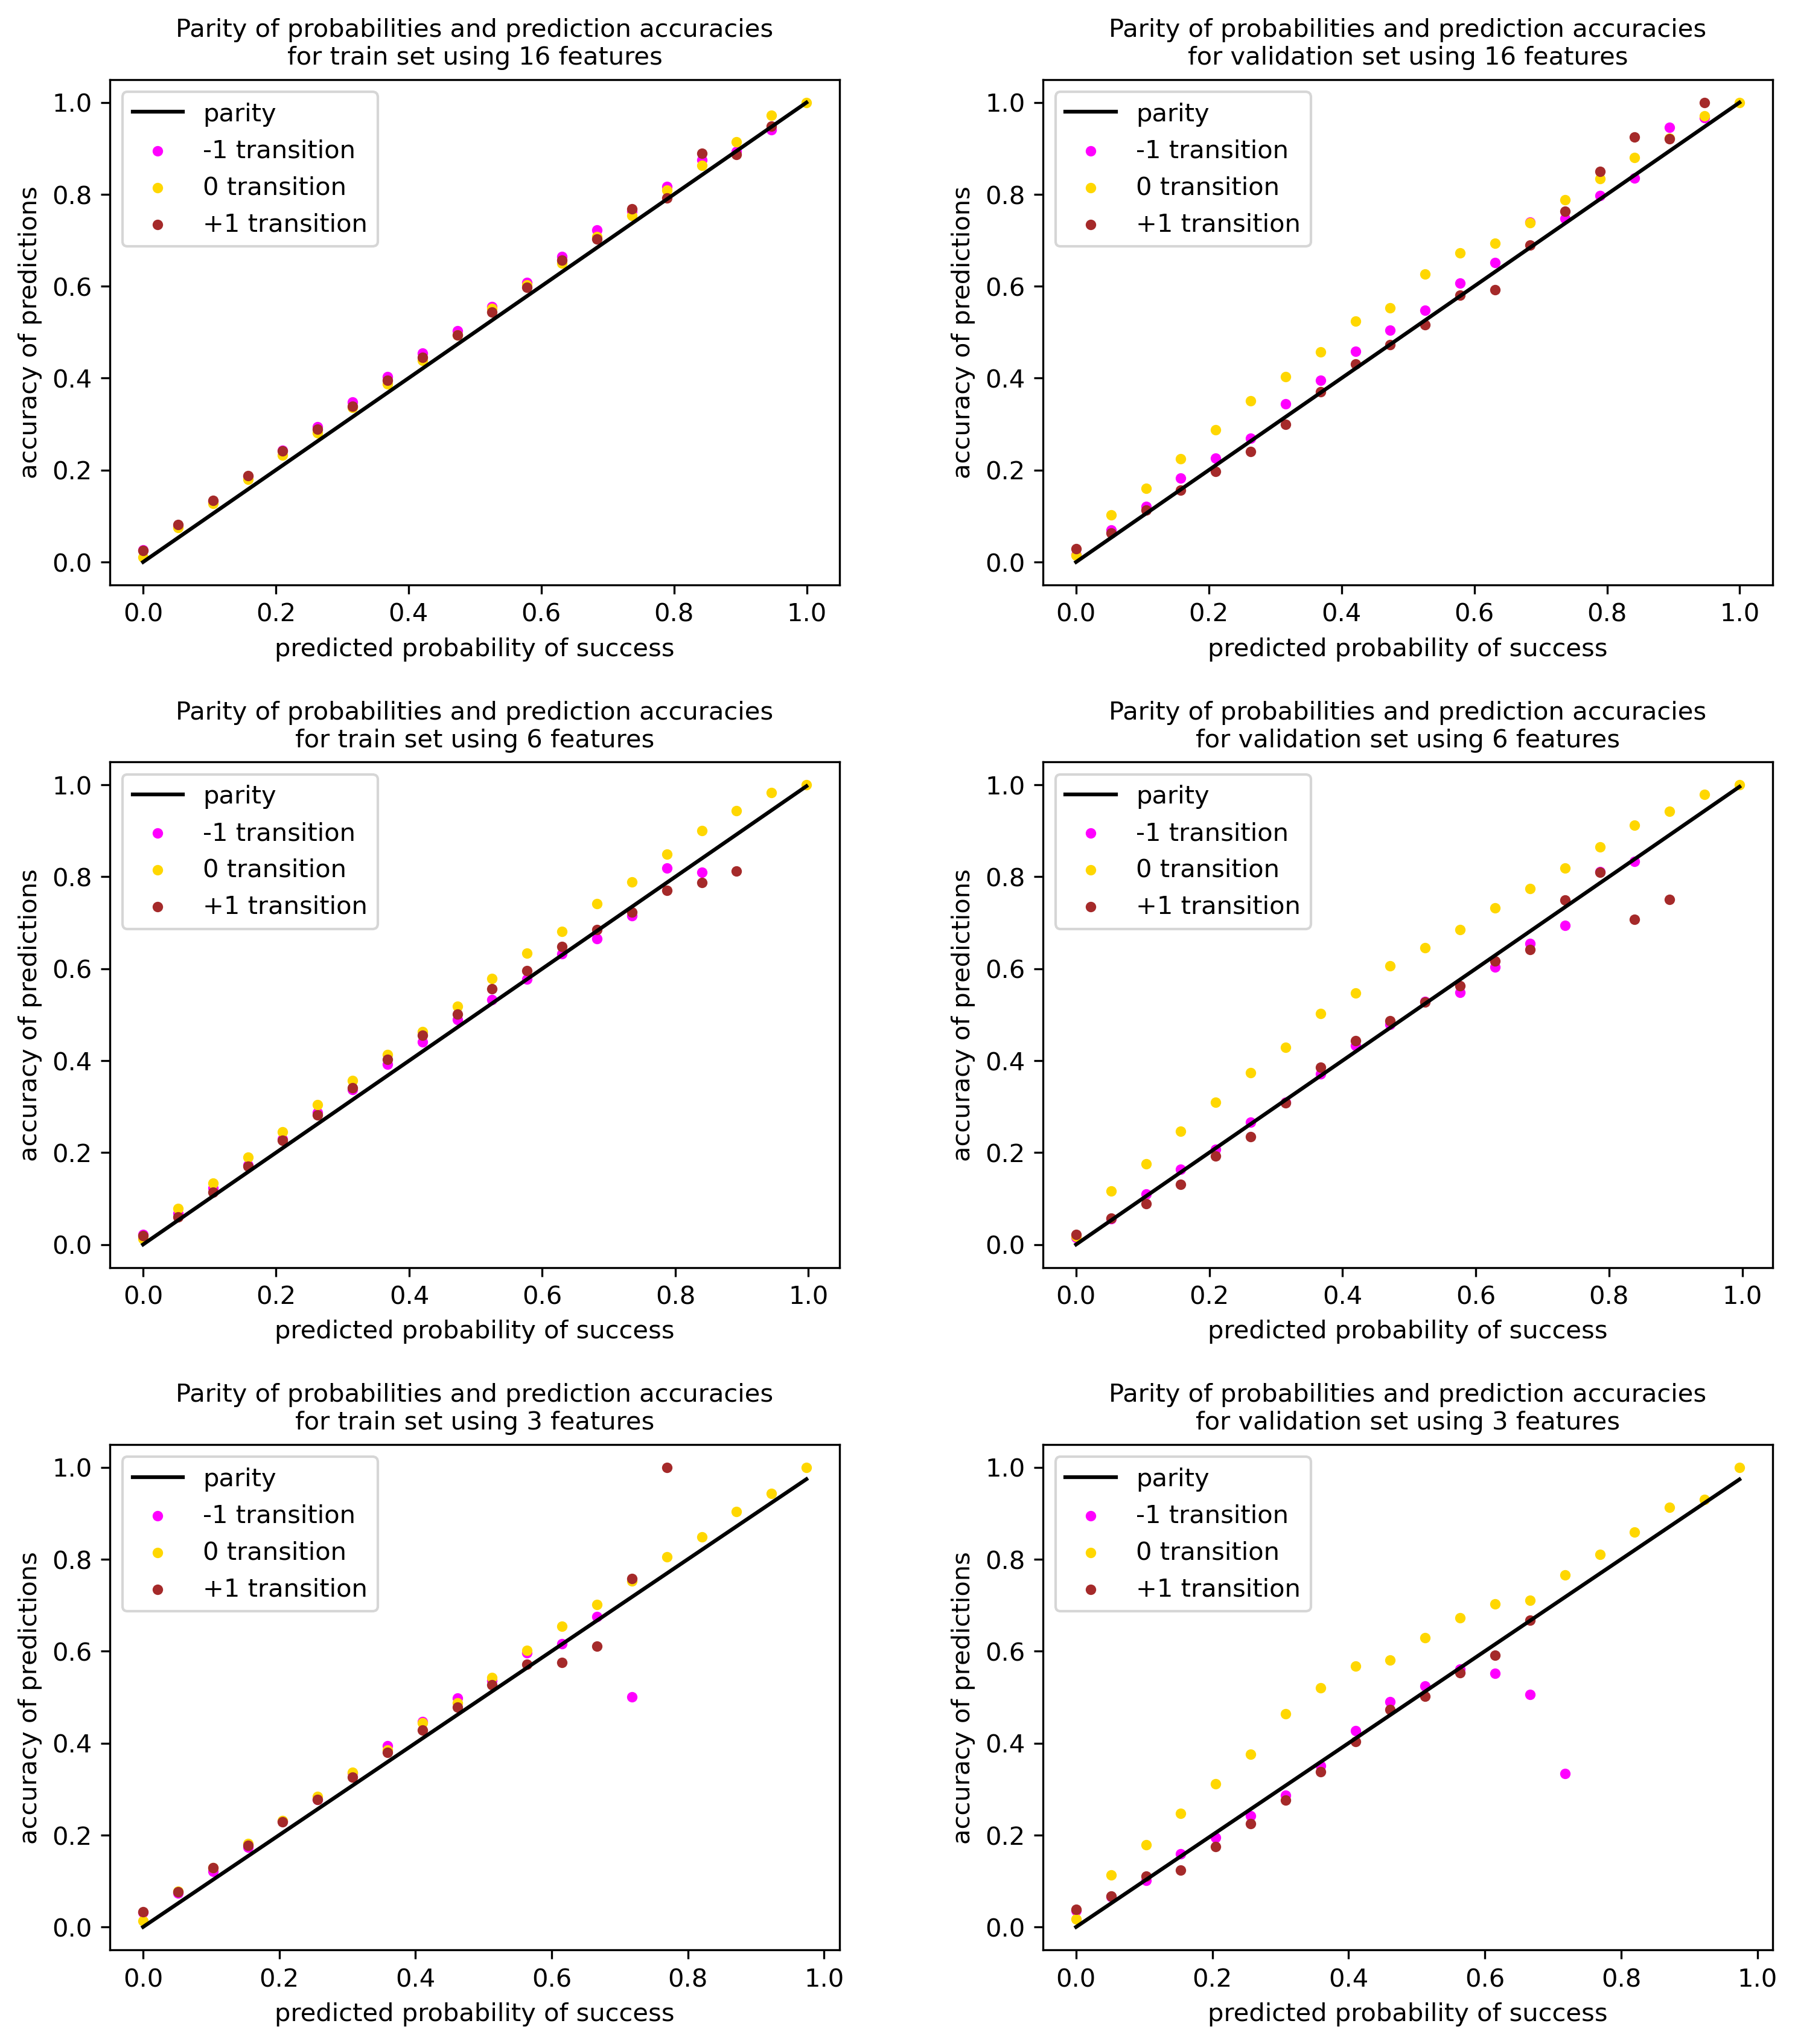

In [52]:

# parity plots for the neural nets

titles = ['Parity of probabilities and prediction accuracies\nfor train set',
          'Parity of probabilities and prediction accuracies\nfor validation set']

transition_colors = ['magenta', 'gold', 'brown']

num_features = [len(x_train.columns)] + top_num_features
num_points = 20

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 12), dpi=300)

fig.tight_layout(pad=5.0)

for row in range(3):
    n_features = num_features[row]
    
    for col in range(2):
        if col == 0:
            x_data = x_train[ordered_features[:n_features]]
            y_data = y_ohe(y_train)
            
        else:
            x_data = x_vali[ordered_features[:n_features]]
            y_data = y_ohe(y_vali)
            
        x_parity, y_parity = get_parity(y_data, neural_nets[n_features].predict(x_data), num_points)
        
        axes[row][col].set_title(titles[col] + ' using ' + str(num_features[row]) + ' features', fontsize=10)
        axes[row][col].set_xlabel('predicted probability of success', fontsize=10)
        axes[row][col].set_ylabel('accuracy of predictions', fontsize=10)
        axes[row][col].plot(x_parity, x_parity, c='black')
        
        for transition in range(3):
            axes[row][col].scatter(x_parity, y_parity[transition], c=transition_colors[transition], s=10)
            
        axes[row][col].legend(['parity', '-1 transition', '0 transition', '+1 transition'])
        
plt.show()


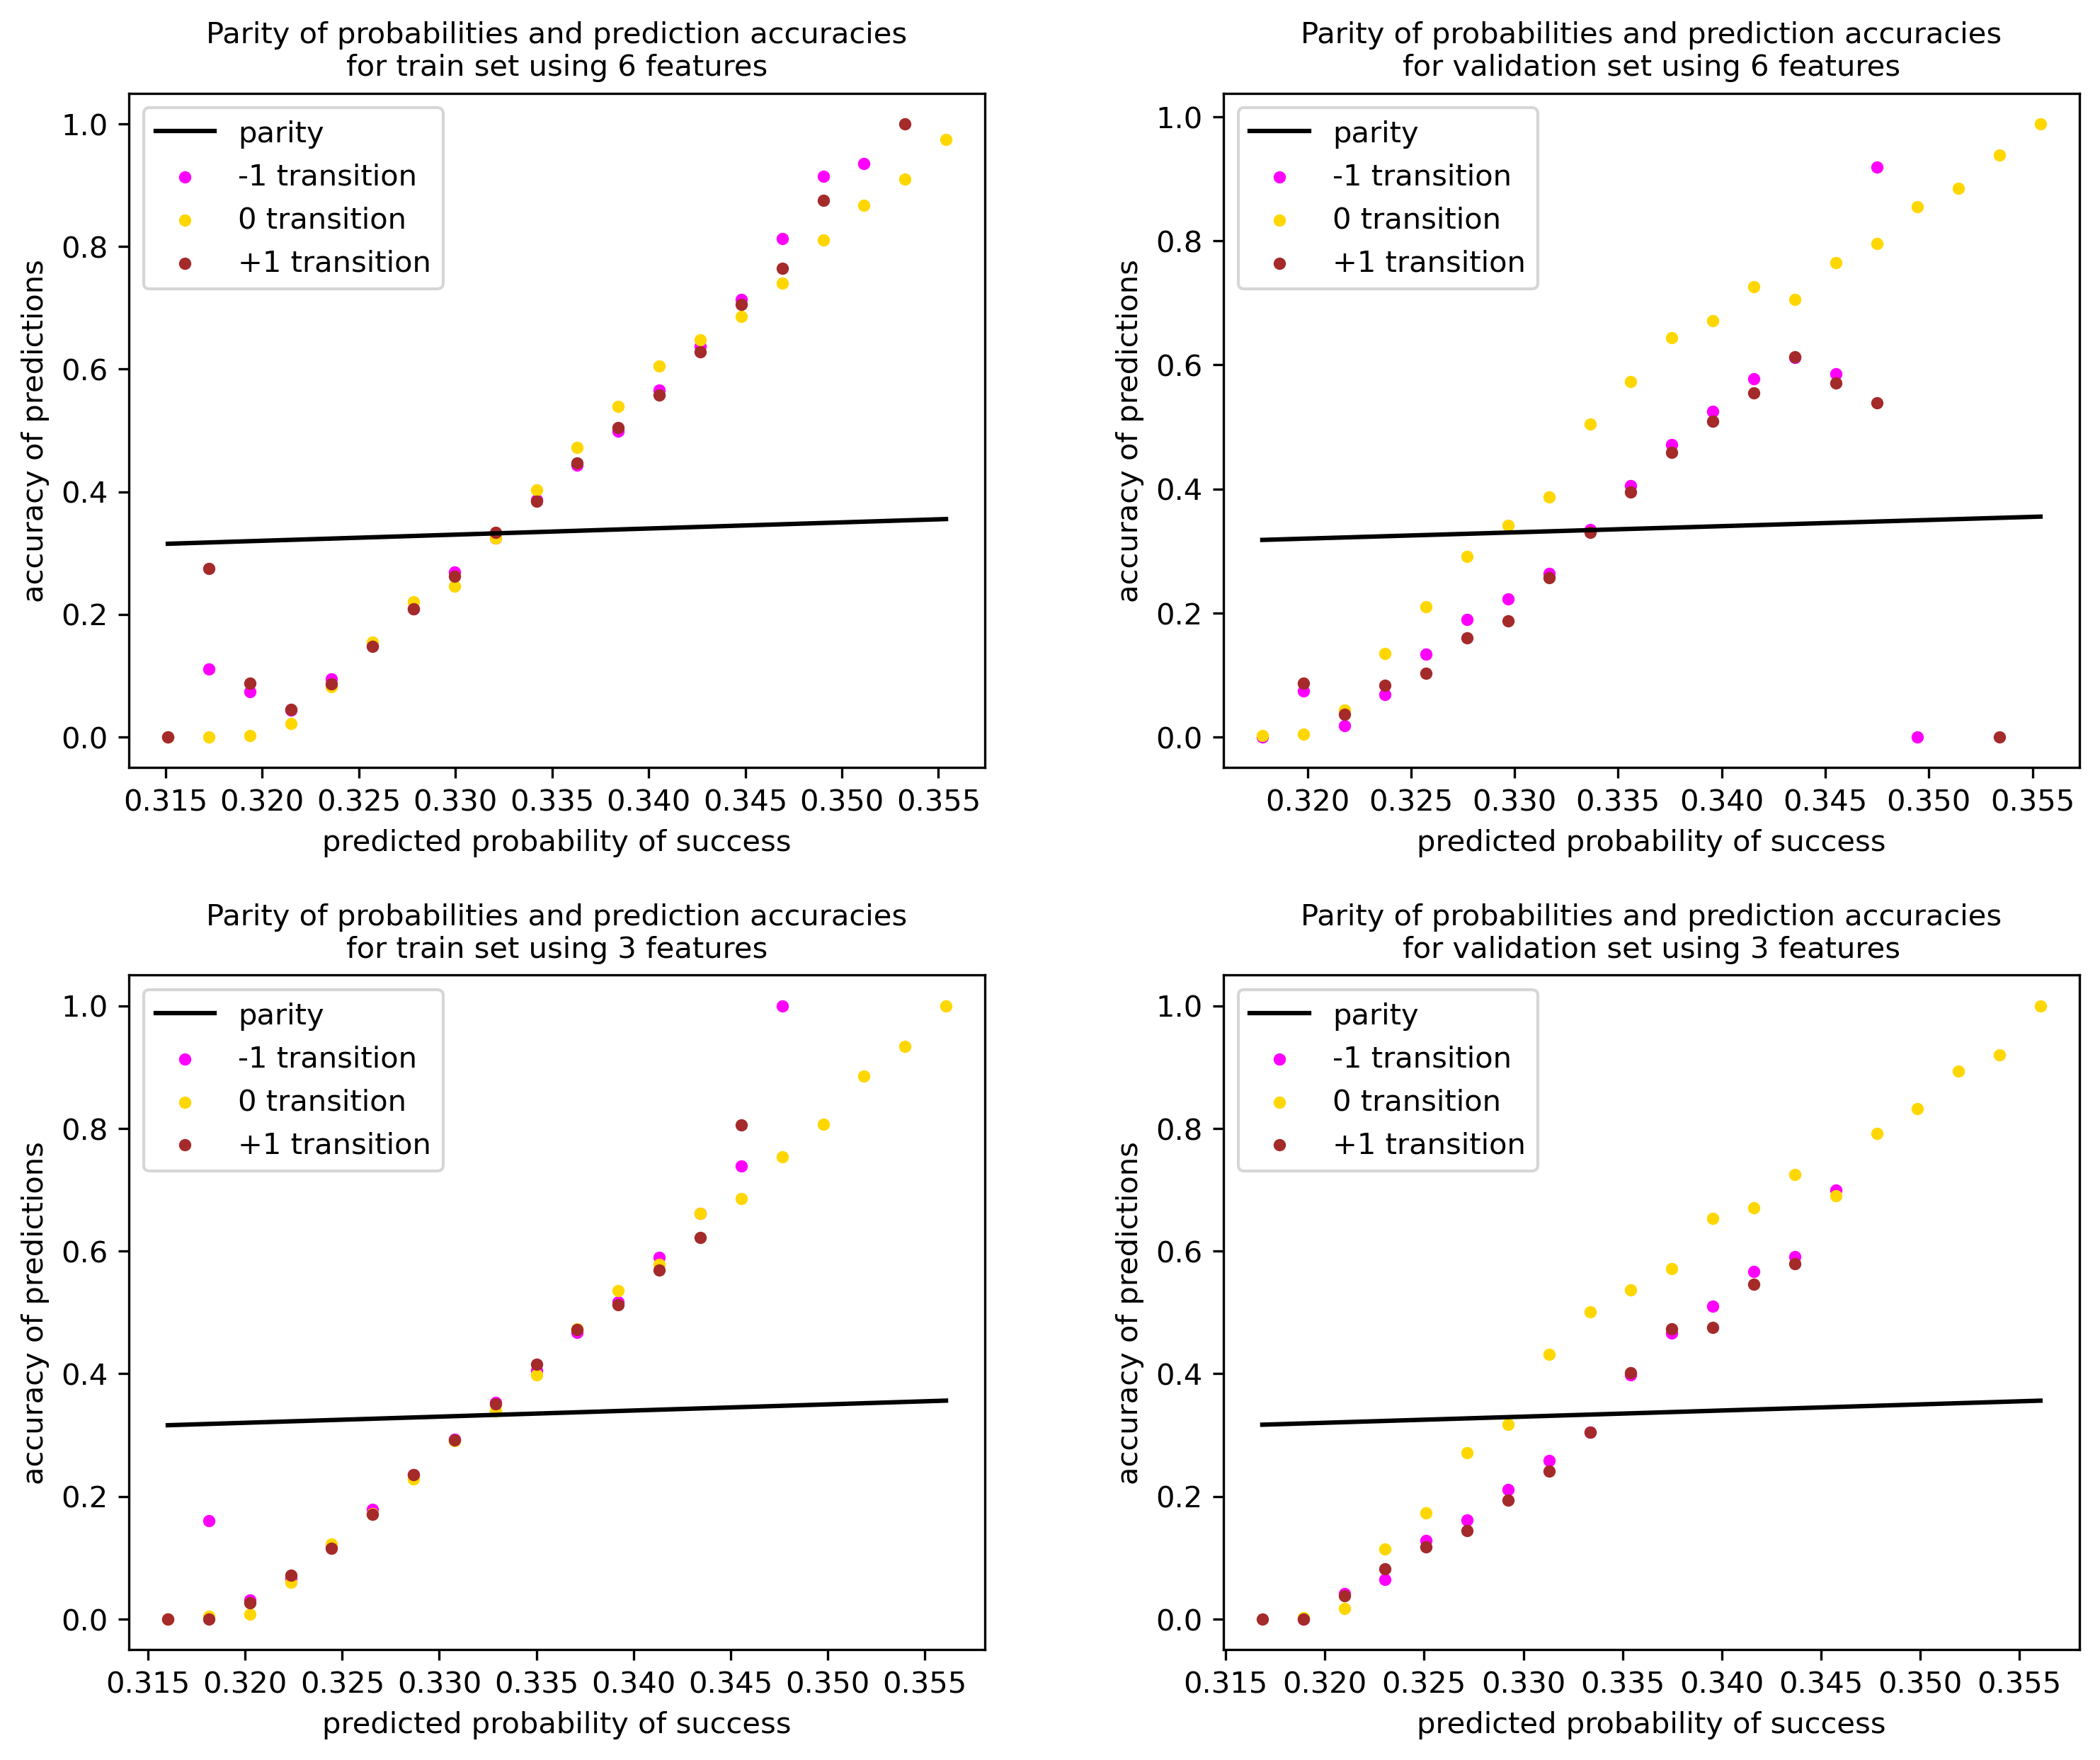

In [53]:

# parity plots for the XGB models

titles = ['Parity of probabilities and prediction accuracies\nfor train set',
          'Parity of probabilities and prediction accuracies\nfor validation set']

transition_colors = ['magenta', 'gold', 'brown']

num_features = top_num_features
num_points = 20

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 9), dpi=300)

fig.tight_layout(pad=5.0)

for row in range(2):
    n_features = num_features[row]
    
    for col in range(2):
        if col == 0:
            x_data = x_train[ordered_features[:n_features]]
            y_data = y_ohe(y_train)
            
        else:
            x_data = x_vali[ordered_features[:n_features]]
            y_data = y_ohe(y_vali)
            
        x_parity, y_parity = get_parity(y_data, final_models[n_features].predict_proba(x_data), num_points)
        
        axes[row][col].set_title(titles[col] + ' using ' + str(num_features[row]) + ' features', fontsize=10)
        axes[row][col].set_xlabel('predicted probability of success', fontsize=10)
        axes[row][col].set_ylabel('accuracy of predictions', fontsize=10)
        axes[row][col].plot(x_parity, x_parity, c='black')
        
        for transition in range(3):
            axes[row][col].scatter(x_parity, y_parity[transition], c=transition_colors[transition], s=10)
            
        axes[row][col].legend(['parity', '-1 transition', '0 transition', '+1 transition'])
        
plt.show()


#### Conclusions
Based on the parity plots: <br>
* We can see that the neural nets are much better at predicting probabilities than the XGB models. <br>
* Using all (the 6 most important) features seem to have the highest parity for neural nets (XGB models). <br>

Based on this information, all the features will be used in the final model, and the final model will be the neural net. <br>


### Strategy Development

With this model, we can develop both long and short strategies thanks to its predictive capabilities. I will only focus on a long-biased strategy since there are much less restrictions on taking long positions than short positions. With that said, what I'm about to show you can easily be adapted for a short-biased strategy. <br>

I will employ a basic momentum strategy where I open positions on +1 transitions and close on 0 or -1 transitions, or right before the end of the post-market session. Since I know where to close our positions for gains and losses, I can determine the profit-to-loss ratio of each individual trade. With that information and the predicted probabilities of each trade being a success, I can determine exactly which trades to take with the inequality shown below where $P$, $G$, and $R$ is the predicted probability, potential gain, and potential loss for each trade respectively. <br>

$$\huge P(G + R) > R$$

I will size my positions in such a way where each potential trade risks losing the same amount of capital. So in the equation above, $R$ is the same for all potential trades. <br>


In [54]:

# vector function to calculate quantum price levels
def quantum_price_levels(data, transition):
    
    n = data['n'].round(0) + transition
    
    nn = numpy.abs(n)
    l = data['lambda']
    
    c0 = -l * (1.1924 + 33.2383 * nn + 56.2169 * nn * nn) / (1 + 43.6196 * nn)
    c1 = (0.25 * c0 * c0 - 1 / 27) ** 0.5
    
    E = (2 * nn + 1) * ((-c0 / 2 + c1) ** (1 / 3) + (-c0 / 2 - c1) ** (1 / 3)) / data['E0']
    E = 1 + data['std'] * 0.21 * E
    
    return data['previous_days_close'] * E * (n >= 0) + data['previous_days_close'] / E * (n < 0)

def calc_profit_and_buy_signals(data, R): # calculate profit for potential trades and buy signals
    
    # if transition == 0, we don't know the last traded price so I assume that it's near the -1 transition price
    transition_dir = data['transition'].replace(0, -1, inplace=False)
    G = R * data['reward_per_share'] / data['risk_per_share']
    
    data['profit'] = (transition_dir == 1) * G - (transition_dir != 1) * R
    data['buy_signal'] = (data['chance_of_+1_transition'] * (G + R)) > R
    
def calc_risk_and_reward(data):
    
    data['lower_transition_price'] = quantum_price_levels(data, -1)
    data['upper_transition_price'] = quantum_price_levels(data, 1)
    data['current_price'] = quantum_price_levels(data, 0)
    
    data['risk_per_share'] = data['current_price'] - data['lower_transition_price']
    data['reward_per_share'] = data['upper_transition_price'] - data['current_price']
    

In [55]:

potential_loss = 1000.0 # risk 1000 dollars per trade - this can be any positive number

inverse_transform(train_data, scaler)
inverse_transform(vali_data, scaler)
inverse_transform(test_data, scaler)

train_data['chance_of_+1_transition'] = neural_nets[16].predict(x_train[ordered_features[:16]])[...,2]
vali_data['chance_of_+1_transition'] = neural_nets[16].predict(x_vali[ordered_features[:16]])[...,2]
test_data['chance_of_+1_transition'] = neural_nets[16].predict(x_test[ordered_features[:16]])[...,2]

del x_train
del x_vali
del x_test

del y_train
del y_vali
del y_test

calc_risk_and_reward(train_data)
calc_risk_and_reward(vali_data)
calc_risk_and_reward(test_data)

calc_profit_and_buy_signals(train_data, potential_loss)
calc_profit_and_buy_signals(vali_data, potential_loss)
calc_profit_and_buy_signals(test_data, potential_loss)


3802/3802 [==============================] - 4s 988us/step


Handle nulls if necessary.

In [56]:

print(train_data.isnull().sum(), '\n\n')
print(vali_data.isnull().sum(), '\n\n')
print(test_data.isnull().sum(), '\n\n')

# since there are only a few nulls, we can just remove them
train_data.dropna(inplace=True)
vali_data.dropna(inplace=True)
test_data.dropna(inplace=True)


vsum                       0
rolling_vsum               0
rolling_csum               0
dp                         0
dt                         0
n_time                     0
price                      0
size                       0
n                          0
transition                 0
t_time                     0
throughtput                0
previous_days_close        0
average_volume             0
symbol                     0
mean                       0
std                        0
p(-dx)                     0
p(+dx)                     0
E0                         0
lambda                     0
time_of_day                0
relative_volume            0
chance_of_+1_transition    0
lower_transition_price     0
upper_transition_price     0
current_price              0
risk_per_share             0
reward_per_share           0
profit                     0
buy_signal                 0
dtype: int64 


vsum                       0
rolling_vsum               0
rolling_csum               

Next, I will simulate the execution of the strategy on the train set order to determine the maximum drawdown. This is done so we can better determine the following : <br>
* How much capital I should allocate to this strategy given how much I am willing to risk.
* How large of a drawdown should we accept before we stop using this strategy.


In [57]:

def find_max_drawdowns(profit, num_paths):
    
    max_drawdowns = []
    random_generator = numpy.random.default_rng()
    
    for i in range(num_paths):
        path = random_generator.permutation(profit, axis=-1).cumsum(axis=-1)
        cmax = numpy.maximum.accumulate(path)
        
        max_drawdowns.append((cmax - path).max())
        
    return numpy.array(max_drawdowns)

def get_distribution(values, bins):
    
    lowest = min(values)
    highest = max(values)
    
    width = (highest - lowest) / bins
    
    x = [lowest + width * i for i in range(bins)]
    
    y = [int(bins * (i - lowest) / (highest - lowest)) for i in values]
    y = [len([j for j in y if j==i]) for i in range(bins)]
    
    return x, y, 0.95 * width


MAXIMIM LOSS ON TRAIN SET : 116100.44756917842


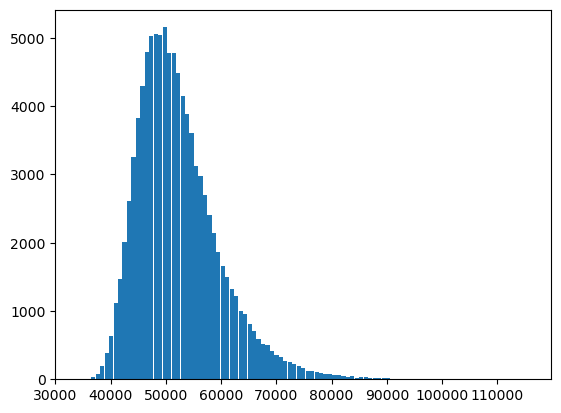

In [58]:

drawdown_paths = 100000
train_losses = find_max_drawdowns(train_data[train_data['buy_signal']]['profit'], drawdown_paths)

max_loss = train_losses.max()

print('MAXIMIM LOSS ON TRAIN SET :', max_loss)
plt.bar(*get_distribution(train_losses, 101))
plt.show()


From the figure above we can see the distribution of potential maximum losses. Next, I will construct a cumulative distribution function so I can closely determine how likely I am to reach my risk limit, given the amount of capital I am willing to risk. <br>

In [59]:

# determine the chance of exceeding a maximum loss
def cdf(losses, max_loss):
    
    return len(losses[losses >= max_loss]) / len(losses)


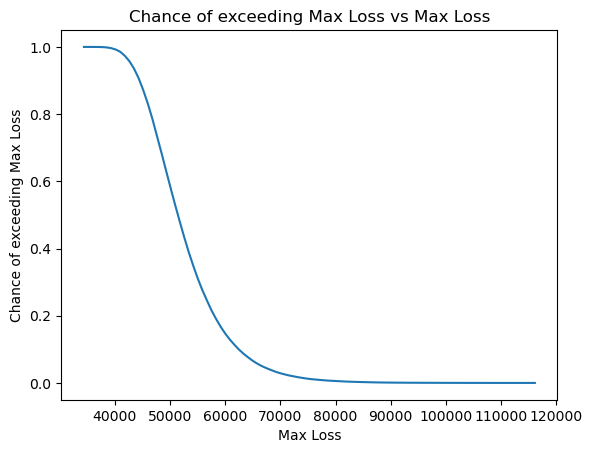

In [60]:

max_losses = train_losses.min() + (max_loss - train_losses.min()) * numpy.arange(100) / 99

plt.plot(max_losses, [cdf(train_losses, i) for i in max_losses])
plt.title('Chance of exceeding Max Loss vs Max Loss', fontsize=12)
plt.ylabel('Chance of exceeding Max Loss')
plt.xlabel('Max Loss')
plt.show()


From the figure above, we can see that the chance of exceeding our maximum loss greatly decreases after going above 80000. The chance of our strategy losing ~116000$ is less a roughly 1 in 100000 chance. Given that I definitely won't productionize anywhere near 100000 trading strategies in my lifetime, I'd take those odds. <br>

Now let's see if a max loss of ~116000 gives us a similar chance of failure on the validation data.

In [61]:

vali_losses = find_max_drawdowns(vali_data[vali_data['buy_signal']]['profit'], drawdown_paths)

print(f'CHANCE OF EXCEEDING {max_loss} IN LOSSES FOR VALIDATION SET :', cdf(vali_losses, max_loss))


CHANCE OF EXCEEDING 116100.44756917842 IN LOSSES FOR VALIDATION SET : 0.00705


The chance of exceeding 116000 in losses for the validation set is roughly 0.7%. That is considerably higher (but more realistic) than what was obtained on the train set. <br>

Next, I will simulate the strategy on the training set with different amounts of initial capital in order to see how much we need to maximize profit.


In [62]:

# turn transitions into buy and sell events so we can simulate the trading strategy
def get_events(data):
    
    events = data[data['buy_signal']]
    
    events.dropna(inplace=True)
    
    buy_events = events[['buy_price', 'n_time', 'risk_per_share']]
    sell_events = events[['sell_price', 't_time', 'risk_per_share']]
    
    buy_events['event'] = 1 # 1 for buy
    sell_events['event'] = 0 # 0 for sell
    
    buy_events['id'] = numpy.arange(len(events))
    sell_events['id'] = numpy.arange(len(events))
    
    buy_events.rename(columns={'buy_price':'price', 'n_time':'time'}, inplace=True)
    sell_events.rename(columns={'sell_price':'price', 't_time':'time'}, inplace=True)
    
    events = pandas.concat([buy_events, sell_events], axis=0)
    
    events.sort_values(['time', 'event'], ascending=[True, False], inplace=True)
    
    return events

# execute the trading strategy with some initial capital and return the total profit for different values
# does not account for cash settlement so initial_capital must be and stay over 25000 the whole time in ...
# ... order for this to be accurate, or we assume we always have 25000 in the account so we don't have to worry about that
def get_profits(events, initial_capitals):
    
    final_capitals = []
    
    for capital in initial_capitals:
        current_positions = {} # keep track of the stocks we are holding - each item = (event_id, position_size)
        
        for index, price, time_ns, risk, event_type, event_id in events.itertuples():
            if price < 1.0: price = round(price, 4)
            else: price = round(price, 2)
            
            if event_type: # if this is a buy event
                if capital >= price: # if there is at least enough cash for one share
                    position_size = (min(capital / price, potential_loss / risk)) // 1
                    
                    if position_size > 0:
                        capital -= position_size * price
                        
                        current_positions[event_id] = position_size
                        
            elif event_id in current_positions: # if we are already holding this position
                capital += current_positions[event_id] * price
                
                del current_positions[event_id]
                
        final_capitals.append(capital)
        
    return numpy.array(final_capitals)

def get_net_gains(data, initial_capitals):
    
    data['buy_price'] = data['current_price']
    data['sell_price'] = quantum_price_levels(data, data['transition'].replace(0, -1, inplace=False))
    
    return get_profits(get_events(data), initial_capitals)

def plot_net_gains(initial_capitals, final_capitals, initial_capital):
    
    plt.scatter(numpy.log10(initial_capitals), final_capitals - initial_capitals)
    
    if initial_capital:
        net_gains = final_capitals - initial_capitals
        plt.scatter([numpy.log10(initial_capital)], net_gains[initial_capitals==initial_capital])
        
    plt.title('Net Gain vs Initial Capital', fontsize=12)
    plt.xlabel('Initial Capital ($log_{10}$)')
    plt.ylabel('Net Gain')
    plt.show()
    

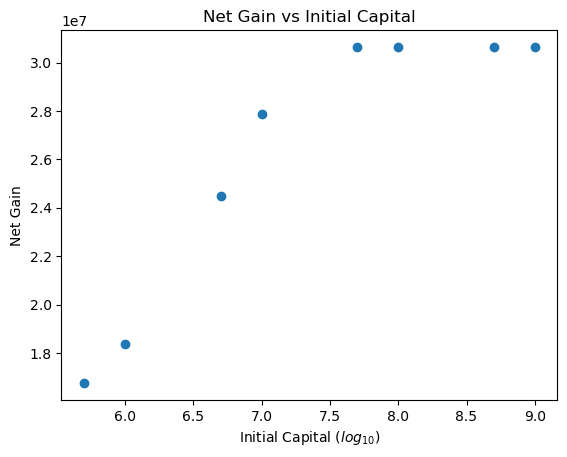

In [63]:

initial_capitals = numpy.array([5e+5, 1e+6, 5e+6, 1e+7, 5e+7, 1e+8, 5e+8, 1e+9])
train_final_capitals = get_net_gains(train_data, initial_capitals)

plot_net_gains(initial_capitals, train_final_capitals, 0)


It looks like some value between 10 and 50 million USD will maximize our gains using this strategy while risking 1000 USD per trade. Despite that, starting with as little as 500k will still generate a considerable profit. I will use 10 million as the initial capital for this strategy. But any value that is at least 500k seems to be good enough to start. <br>

Now let's see if this amount gives us the highest return for the validation set.


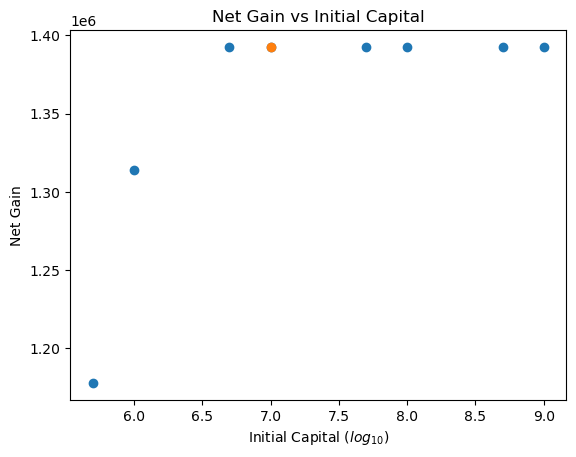

In [64]:

initial_capital = 1e+7 # 10 million USD
vali_final_capitals = get_net_gains(vali_data, initial_capitals)

plot_net_gains(initial_capitals, vali_final_capitals, initial_capital)



It looks like 5 million maximizes the profit on the validation set. This could be the case because of the short time horizon. <br>

The only thing left to do is evaluate the strategy on the final unseen test set.


### Evaluate the finalized strategy
Find the following for the test set:
* Maximum drawdown
* Initial capital that maximizes profit

<br> Those two quantities should ideally be the same as their respective train values.


In [65]:

test_losses = find_max_drawdowns(test_data[test_data['buy_signal']]['profit'], drawdown_paths)

print(f'CHANCE OF EXCEEDING {max_loss} IN LOSSES FOR TEST SET :', cdf(test_losses, max_loss))


CHANCE OF EXCEEDING 116100.44756917842 IN LOSSES FOR TEST SET : 0.25828


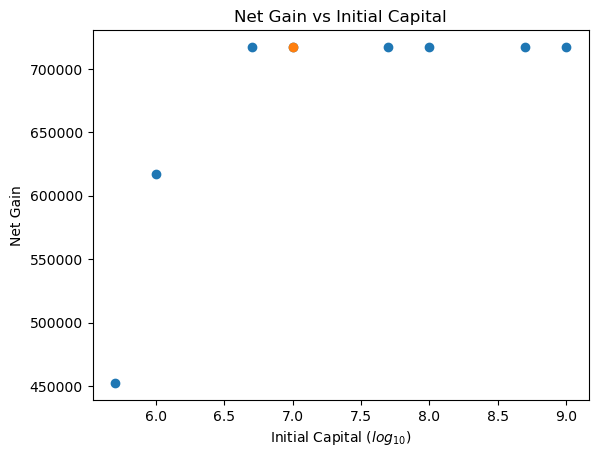

In [66]:

test_final_capitals = get_net_gains(test_data, initial_capitals)

plot_net_gains(initial_capitals, test_final_capitals, initial_capital)


It looks like the strategy still remains profitable during the test period, but the maximum drawdown and initial capital are considerably different. I also performed this analysis including transitions before 2022-01-01 and I found similar - but more obvious - discrepancies. <br>

Despite these drawbacks, I will go ahead and implement this strategy in an automated trading bot.
I will first perform a walk forward optimization with the neural net so I can see if the risk of ruin and profitability improve. A 25% risk of ruin on the test set is not acceptable so hopefully periodically retraining the model will help keep that risk at a lower number.

SEGMENT LENGTH :  138 days 00:59:04.501732062
4078/4078 [==============================] - 4s 992us/step

FROM  2020-01-02 10:04:13.635000064  TO  2023-05-28 18:55:54.150588672
MAXIMIM LOSS ON TRAIN SET : 119945.15924591385
CHANCE OF EXCEEDING 119945.15924591385 IN LOSSES FOR TEST SET : 0.01724 



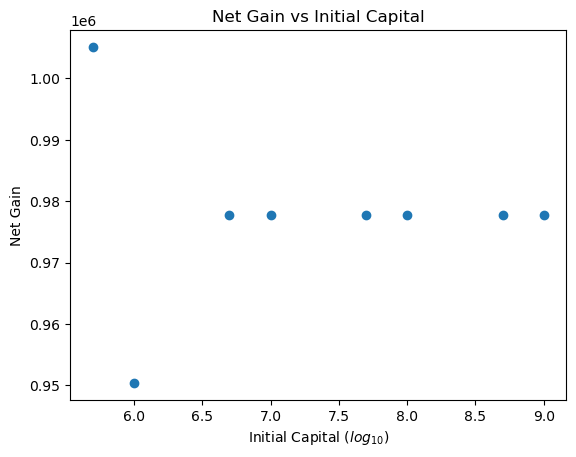

4112/4112 [==============================] - 4s 1ms/step

FROM  2020-05-19 11:03:18.136732160  TO  2023-10-13 19:54:58.652320768
MAXIMIM LOSS ON TRAIN SET : 119951.15196564421
CHANCE OF EXCEEDING 119951.15196564421 IN LOSSES FOR TEST SET : 0.00012 



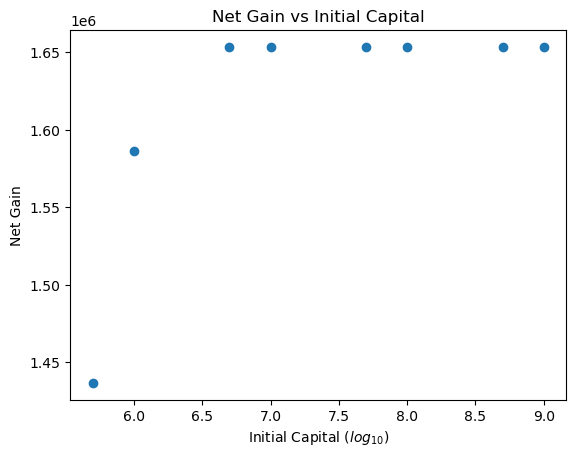

In [67]:

# transition_data = transition_data

# time_max = transition_data.n_time.max()
# time_min = transition_data.n_time.min()

# ordered_features = ordered_features
# num_features = num_features
num_features = 16

# potential_loss = potential_loss
# drawdown_paths = drawdown_paths

# initial_capitals = numpy.array([])

total_segments = 10
train_segments = 8
test_segments = 1

full_period = time_max - time_min
segment_period = full_period / total_segments

print('SEGMENT LENGTH : ', pandas.Timedelta(segment_period))

for segment in range((total_segments - train_segments) // test_segments):
    train_start = time_min + segment_period * segment * test_segments
    train_end = train_start + segment_period * train_segments
    
    test_start = train_end
    test_end = test_start + segment_period * test_segments
    
    train_data = transition_data[(transition_data.n_time > train_start) & (transition_data.n_time <= train_end)]
    test_data = transition_data[(transition_data.n_time > test_start) & (transition_data.n_time <= test_end)]
    
    scaler = StandardScaler()
    
    transform(train_data, scaler, True)
    transform(test_data, scaler)
    
    remove_outliers(train_data)
    remove_outliers(test_data)
    
    x_train = train_data[features]
    x_test = test_data[features]
    
    y_train = train_data[target]
    y_test = test_data[target]
    
    model = construct_and_train_nn(x_train[ordered_features[:num_features]], y_ohe(y_train), 32, 16, 3)
    
    inverse_transform(train_data, scaler)
    inverse_transform(test_data, scaler)

    train_data['chance_of_+1_transition'] = model.predict(x_train[ordered_features[:num_features]])[...,2]
    test_data['chance_of_+1_transition'] = model.predict(x_test[ordered_features[:num_features]])[...,2]
    
    del x_train
    del x_test
    
    del y_train
    del y_test
    
    calc_risk_and_reward(train_data)
    calc_risk_and_reward(test_data)
    
    calc_profit_and_buy_signals(train_data, potential_loss)
    calc_profit_and_buy_signals(test_data, potential_loss)
    
    train_data.dropna(inplace=True)
    test_data.dropna(inplace=True)
    
    train_losses = find_max_drawdowns(train_data[train_data['buy_signal']]['profit'], drawdown_paths)
    test_losses = find_max_drawdowns(test_data[test_data['buy_signal']]['profit'], drawdown_paths)
    
    test_final_capitals = get_net_gains(test_data, initial_capitals)
    
    max_loss = train_losses.max()
    
    print('\nFROM ', pandas.Timestamp(train_start), ' TO ', pandas.Timestamp(test_end))
    print('MAXIMIM LOSS ON TRAIN SET :', max_loss)
    print(f'CHANCE OF EXCEEDING {max_loss} IN LOSSES FOR TEST SET :', cdf(test_losses, max_loss), '\n')
    
    plot_net_gains(initial_capitals, test_final_capitals, 0)
    

It looks like our final step shows a lower risk of ruin and higher profitability than our initial model evaluated on the test set. This suggests that periodically retraining the model is necessary for it to maintain its edge.

We will now train our final model and save its weights and scaler information in customized json format so they can be loaded into the trading bot.

In [68]:

train_start = time_max - segment_period * train_segments
train_data = transition_data[transition_data.n_time > train_start]

scaler = StandardScaler()
    
transform(train_data, scaler, True)

remove_outliers(train_data)

x_train = train_data[features]
y_train = train_data[target]

model = construct_and_train_nn(x_train[ordered_features[:num_features]], y_ohe(y_train), 32, 16, 3)

inverse_transform(train_data, scaler)

train_data['chance_of_+1_transition'] = model.predict(x_train[ordered_features[:num_features]])[...,2]

del x_train
del y_train

calc_risk_and_reward(train_data)
calc_profit_and_buy_signals(train_data, potential_loss)

train_data.dropna(inplace=True)

train_losses = find_max_drawdowns(train_data[train_data['buy_signal']]['profit'], drawdown_paths)

last_max_loss = max_loss
max_loss = train_losses.max()

print('\nFROM ', pandas.Timestamp(train_start), ' TO ', pandas.Timestamp(test_end))
print('MAXIMIM LOSS ON TRAIN SET :', round(max_loss, 2))
print(f'EXPECTED CHANCE OF EXCEEDING {round(max_loss, 2)} :', cdf(test_losses, last_max_loss), '\n')


34366/34366 [==============================] - 38s 1ms/step

FROM  2020-10-04 12:02:22.638464  TO  2023-10-13 19:54:58.652320768
MAXIMIM LOSS ON TRAIN SET : 99282.02
EXPECTED CHANCE OF EXCEEDING 99282.02 : 0.00012 



In [69]:

def save_scaler_info(scaler, input_features, path):
    
    scale_features = list(scaler.feature_names_in_)
    scale_json = '['
    
    print('ORDER OF THE INPUTS\n')
    
    for feature in input_features:
        try:
            mean = scaler.mean_[scale_features.index(feature)]
            std = scaler.var_[scale_features.index(feature)] ** 0.5
            
            scale_json += '{' + f'"feature name": "{feature}", "mean": {mean}, "std": {std}' + '},'
            
            print(feature)
            
        except ValueError: pass # feature is not used in the data transformation
        
    scale_json = scale_json[:-1] + ']'
    
    file = open(path, 'w')
    file.write(scale_json)
    file.close()
    
def save_model_weights(model, path):
    
    jstring = '['
    
    for layer in model.layers:
        jstring += '{"weight_sets":['
        
        for weight in layer.weights:
            jstring += '{"shape":' + str(list(weight.shape))
            jstring += ', "weights":' + str(list(weight.numpy().ravel()))
            jstring += '}, '
            
        if len(layer.weights): jstring = jstring[:-2] + ']}, '
        else: jstring += ']}, '
        
    if len(model.layers): jstring = jstring[:-2] + ']'
    else: raise Exception("Cannot save an empty model.")
    
    file = open(path, 'w')
    file.write(jstring)
    file.close()
    
save_scaler_info(scaler, ordered_features[:num_features], f'{base_dir}scaler_info.json')
save_model_weights(model, f'{base_dir}model_weights.json')


ORDER OF THE INPUTS

time_of_day
relative_volume
n
mean
dp
std
dt
vsum
average_volume
previous_days_close
rolling_csum
rolling_vsum
p(-dx)
size
p(+dx)
lambda


# The End